# Stats 209 Final Project

In [1]:
require(dplyr)
require(ggplot2)
require(tidyverse)
install.packages("glmnet")
require(glmnet)
install.packages("estimatr")
require(estimatr)
install.packages("caret")
require(caret)
install.packages("randomForest")
require(randomForest)
install.packages(c("sandwich", "lmtest"))
require(sandwich)
require(lmtest)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘Rcpp’, ‘RcppEigen’


Loading required package: glmnet

Loadi

## I. Load and clean data

First, load the original datasets from github.

In [ ]:
cyp = read.csv('https://raw.githubusercontent.com/jzywaaaaa/causal_effect_analysis_on_CYP_GUIDES_data/main/data/CYP_GUIDES.csv')
med_keys = read.csv('https://raw.githubusercontent.com/jzywaaaaa/causal_effect_analysis_on_CYP_GUIDES_data/main/data/CYP_medication_keys.csv')

Match the medication names in `med_keys` to the letter-coded columns of medications in the main dataframe `df`.

In [ ]:
# lowercase the medication keys
med_keys$Medication = med_keys$Medication %>% tolower()

# create a dataframe of medications with medication names
df_of_medicines = cyp %>% select(med_keys$Column, "ID")
colnames(df_of_medicines) = c(med_keys$Medication, "ID")

# join that dataframe with the main dataframe
df = cyp %>%
  select(-med_keys$Column) %>%
  merge(df_of_medicines, on = "ID")

# check the dimensions of df
dim(df)

[1] 1500   43

Rename the columns so that they are more intuitive.

In [ ]:
df = df %>%
  rename(
    # new name = old name
    "gender" = "GENDER",
    "age" = "AGE",
    "race" = "RACE.ETHNICITY",
    "diagnosis" = "Diagnosis",
    "physician" = "MD",
    "treatment" = "Assignment",
    "med_record" = "EMR",
    "len_of_stay" = "LOS",
    "readmitted" = "RAR",
    "n_pt_med" = "X..Psychotropic.Medications",
    "n_admin" = "X..Administrations",
    "therapy_guidance" = "Therapeutic.Guidances"
  )

head(df)

,ID,gender,age,race,diagnosis,physician,treatment,med_record,len_of_stay,readmitted,⋯,nortriptyline,olanzapine,paliperidone,perphenazine,quetiapine,risperidone,sertraline,trazodone,venlafaxine,ziprasidone
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,F,49,W,"MDD, Recurrent, Unspecified",L,G,C,70,0,⋯,0,0,0,0,0,0,0,1,0,0
2,2,F,21,W,"MDD, Recurrent, Unspecified",A,G,C,309,0,⋯,0,0,0,0,13,0,0,0,0,0
3,3,M,28,L,"MDD, Single Episode, Severe With Psychotic Features",I,G,C,376,0,⋯,0,8,0,0,0,15,0,4,0,0
4,4,F,63,L,Depressive Disorder NOS,L,G,C,115,0,⋯,0,0,0,0,0,5,0,0,0,0
5,5,M,34,L,"MDD, Single Episode, Severe With Psychotic Features",G,S,C,120,0,⋯,0,0,0,0,5,0,0,0,0,0
6,6,F,24,L,"MDD, Single Episode,Severe Without Psychotic Features",T,S,C,120,0,⋯,0,0,0,0,0,0,0,5,0,0


Check if any NA or empty values exists:

In [ ]:
apply(df, 2, function(x) {sum(is.na(x)) + sum(x == "")})

ID            gender               age              race 
                0                 0                 0                 0 
        diagnosis         physician         treatment        med_record 
                0                 0                41                 0 
      len_of_stay        readmitted          n_pt_med           n_admin 
                0                 0                 0                 0 
 therapy_guidance     amitriptyline      aripiprazole         asenapine 
               41                 0                 0                 0 
        bupropion    chlorpromazine        citalopram      clomipramine 
                0                 0                 0                 0 
        clonidine           doxepin        duloxetine      escitalopram 
                0                 0                 0                 0 
       fluoxetine      fluphenazine       fluvoxamine        guanfacine 
                0                 0                 0                 0 
      haloperidol        imipramine lithium carbonate   methylphenidate 
                0                 0                 0                 0 
      mirtazapine     nortriptyline        olanzapine      paliperidone 
                0                 0                 0                 0 
     perphenazine        quetiapine       risperidone        sertraline 
                0                 0                 0                 0 
        trazodone       venlafaxine       ziprasidone 
                0                 0                 0

Drop the rows with an empty treatment (there are 41 of them).

In [ ]:
df = df[df$treatment != "",]

The final treatment breakdown is 477 standard therapy (Group S) and 982 to medications primarily metabolized by the CYP2D6 enzyme (Group G). Change the treatment into 1/0 with 1 corresponding to receiving gene-guided therapy and 0 corresponding to receiving traditional therapy.

In [ ]:
df$treatment = (df$treatment == "G") %>% as.numeric()
table(df$treatment)


  0   1 
477 982 

We also need to take care of the `diagnosis` column which consists of long string description of each patient's conditions. An example is "MDD, Single Episode,Severe Without Psychotic Features". This column contains mainly three pieces of information:

* what the diagonsis of a patient is;
* whether the disease is recurrent or single episode;
* whether the conditions are severe, mild/moderate, or not specified.

Hence, we convert the `diagnosis` column into three columns: `condition`, `recurrence`, `severity`.

In [ ]:
condition = numeric(nrow(df))
recurrence = numeric(nrow(df))
severity = numeric(nrow(df))

for (i in 1:nrow(df)) {
  d = df$diagnosis[i] %>% tolower()

  # diagnosis
  if (grepl("mdd", d)|grepl("major depressive disorder", d)) {
    condition[i] = "MDD"
  } else if (grepl("depressive disorder nos", d)) {
    condition[i] = "Depressive Disorder NOS"
  } else {
    condition[i] = "other"
  }

  # recurrence
  if (grepl("recurrent", d)) {
    recurrence[i] = "recurrent"
  } else if (grepl("single", d)) {
    recurrence[i] = "single episode"
  } else {
    recurrence[i] = "unspecified"
  }

  # severity
  if (grepl("severe", d)) {
    severity[i] = "severe"
  } else if (grepl("moderate", d)|grepl("mild", d)) {
    severity[i] = "moderate"
  } else {
    severity[i] = "unspecified"
  }
}

df$condition = condition
df$recurrence = recurrence
df$severity = severity

Check the distributions of the categorical variables to make sure that there is not a level with too few variables:

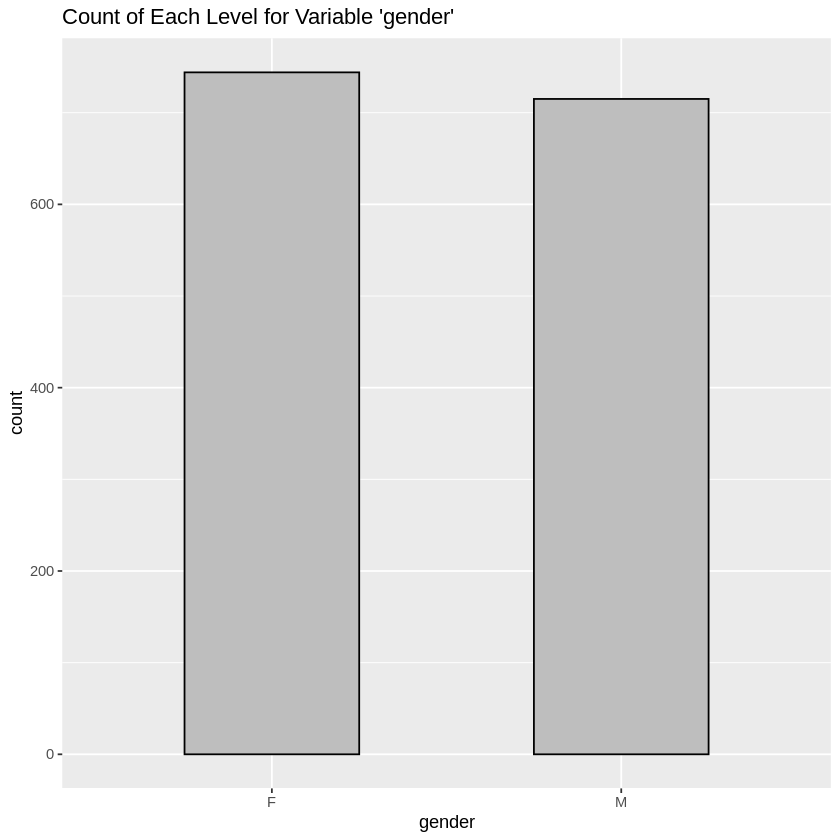

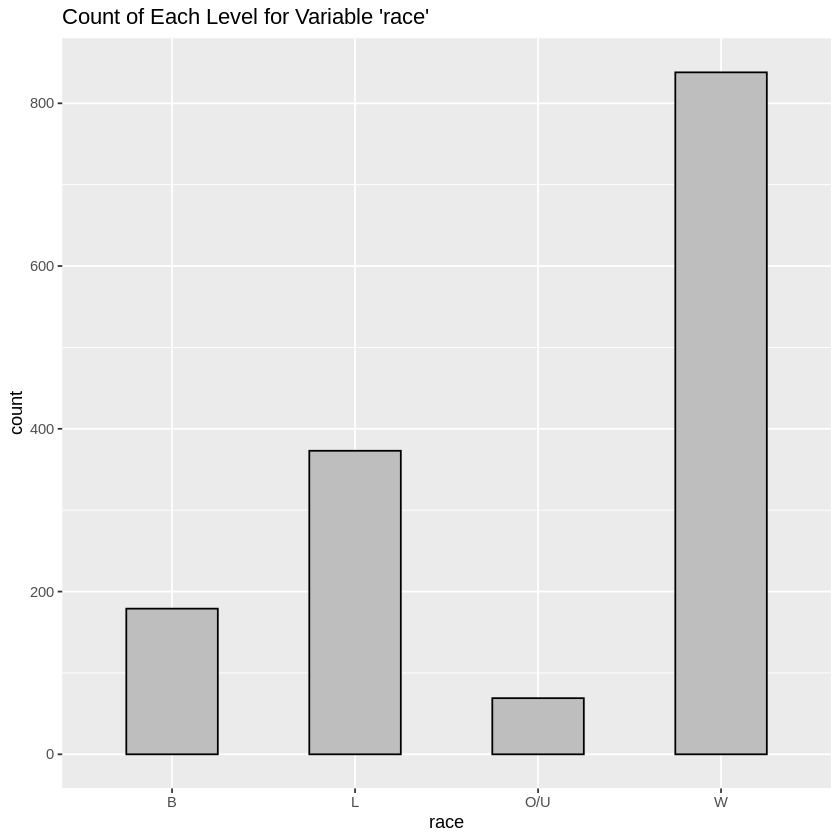

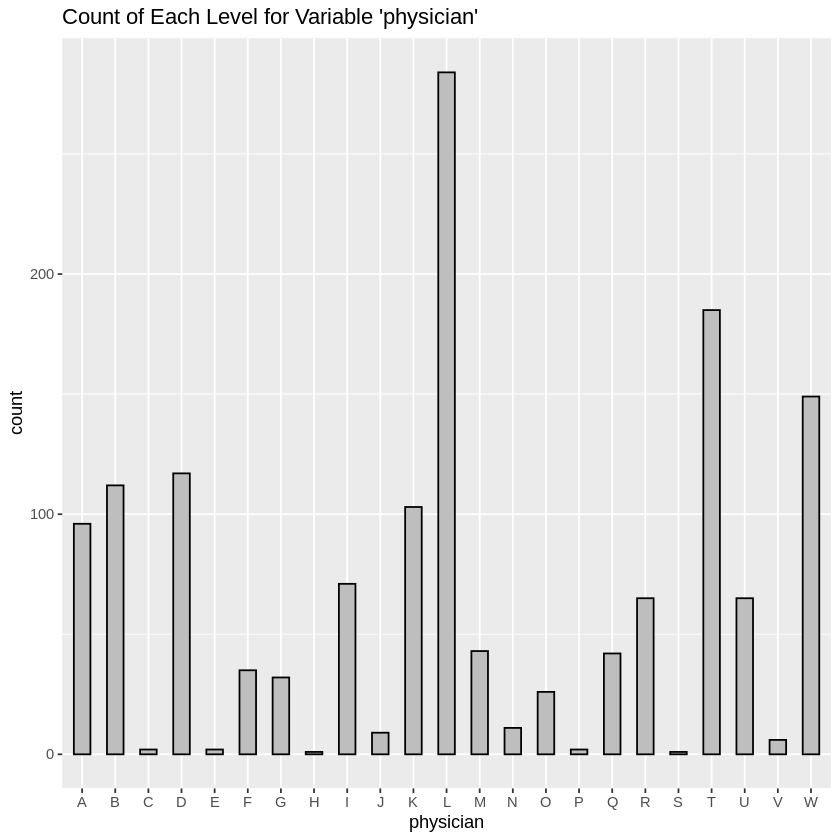

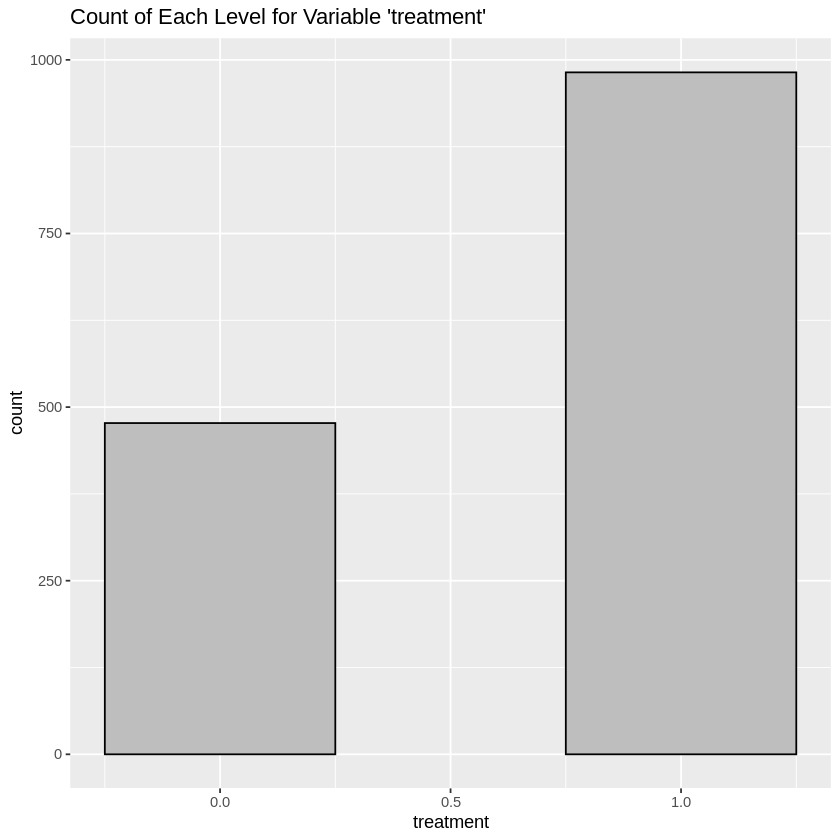

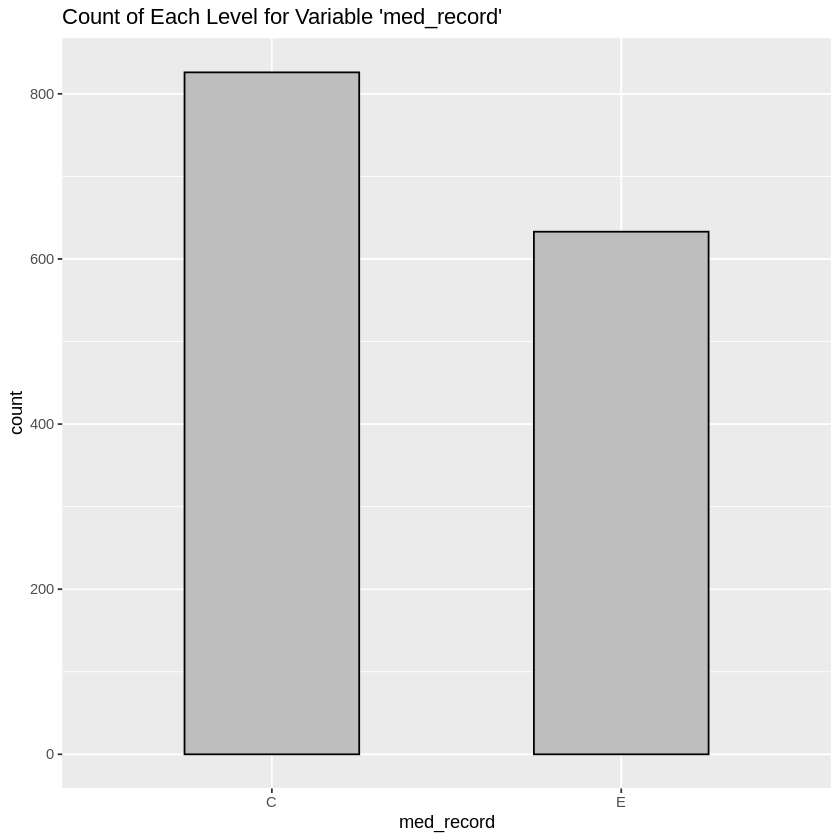

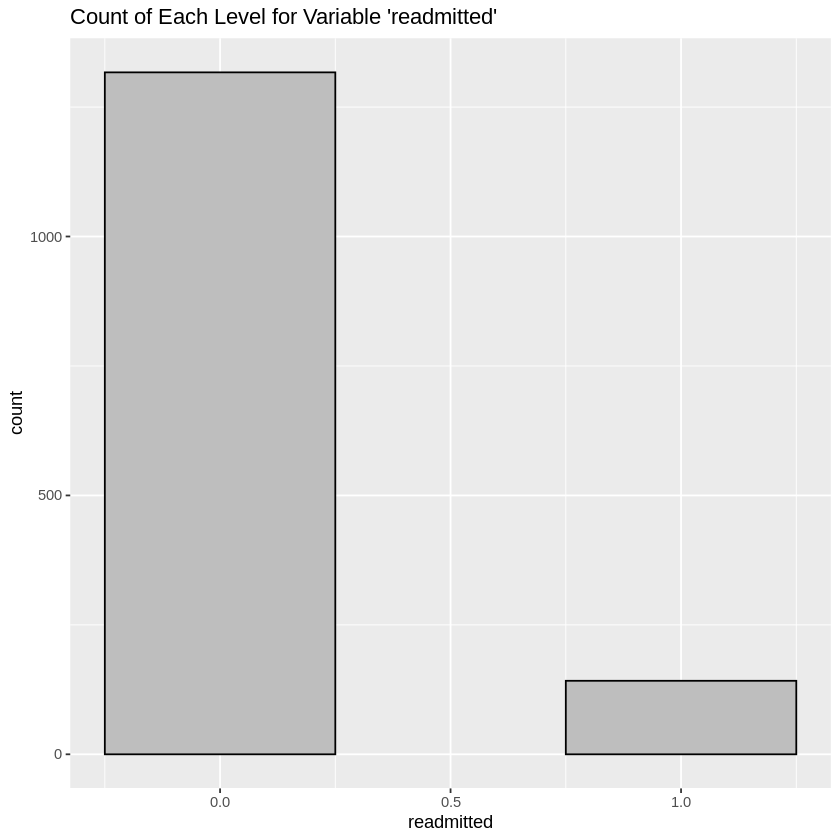

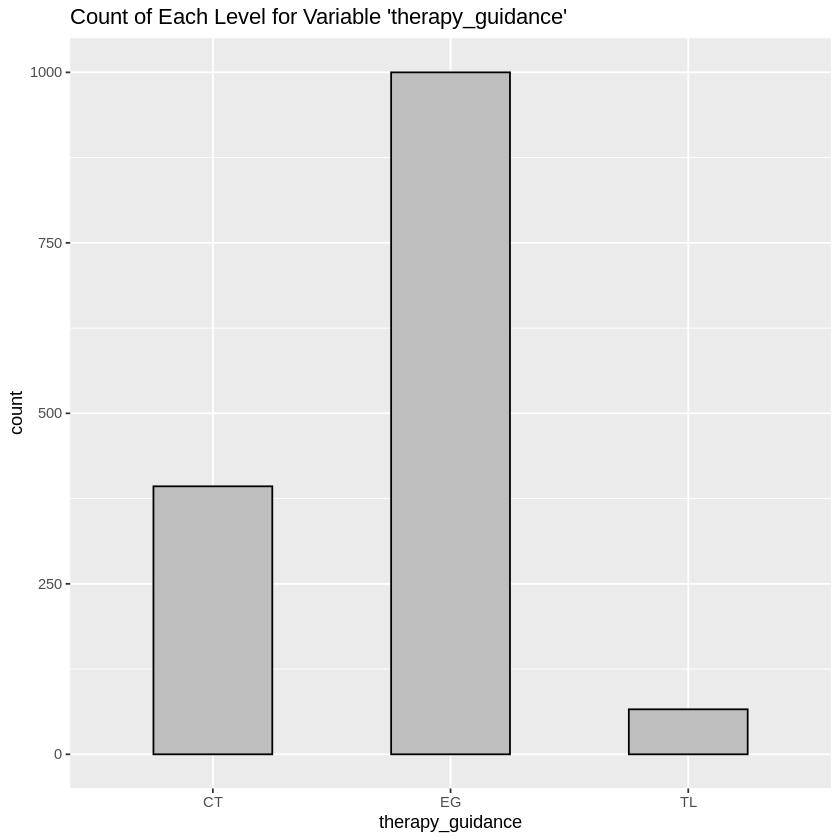

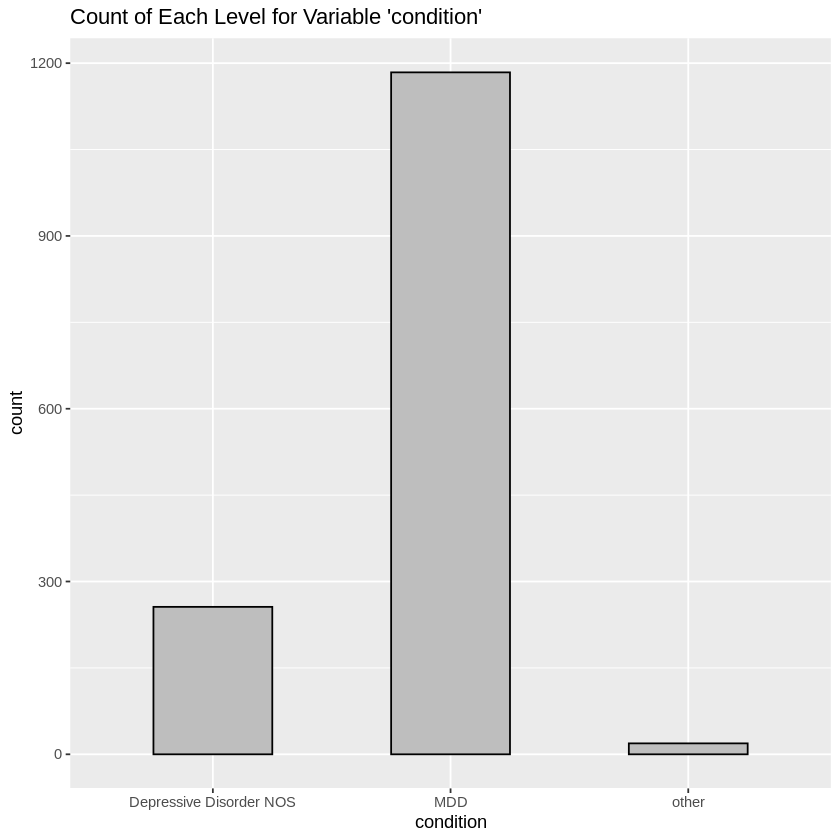

$gender

$race

$physician

$treatment

$med_record

$readmitted

$therapy_guidance

$condition

$severity

$recurrence


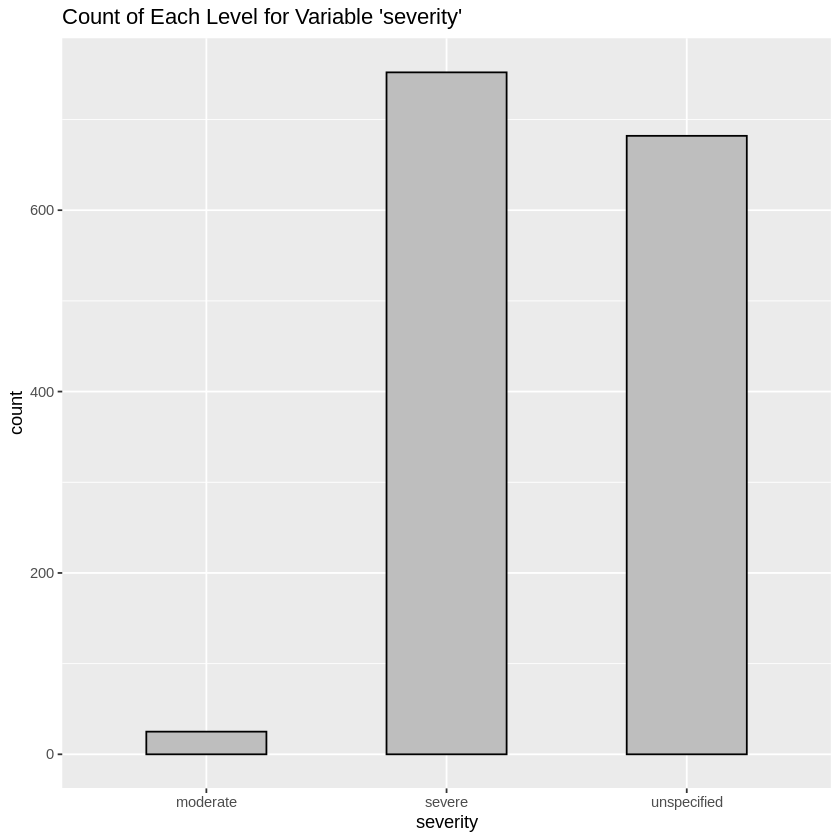

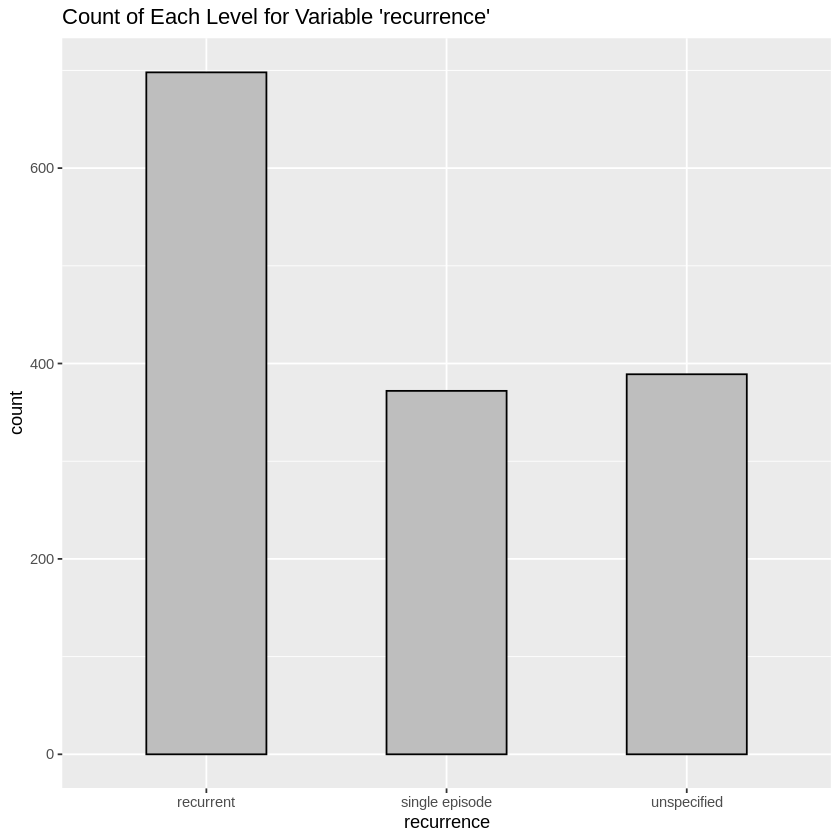

In [ ]:
categorical_cols = c("gender", "race", "physician", "treatment", "med_record",
"readmitted", "therapy_guidance", "condition", "severity", "recurrence")

plots_list = list()

for (col_name in categorical_cols) {

  p = ggplot(df, aes_string(x = col_name)) +
    geom_bar(col = "black", fill = "grey", width = 0.5) +
    #geom_text(stat = 'count', aes(label=after_stat('count')), vjust = -1) +
    xlab(col_name) +
    ggtitle(paste("Count of Each Level for Variable '", col_name, "'", sep = ""))

  plots_list[[col_name]] = p
}

plots_list

We can see that there are our response `readmitted` is rather unbalanced. We cannot do anything to that, but it is something to be aware of in future analysis.

The covariate `physician` is also pretty unbalanced. We merge the classes with under 20 records in them to one big class called "others":

In [ ]:
df$physician %>% table()

.
  A   B   C   D   E   F   G   H   I   J   K   L   M   N   O   P   Q   R   S   T 
 96 112   2 117   2  35  32   1  71   9 103 284  43  11  26   2  42  65   1 185 
  U   V   W 
 65   6 149 

In [ ]:
new_physician = numeric(nrow(df))
for (i in 1:nrow(df)) {
  value = df$physician[i]
  if (value %in% c("C", "E", "H", "J", "N", "P", "S", "V")) {
    new_physician[i] = "other"
  } else {
    new_physician[i] = value
  }
}
df$physician = new_physician
df$physician %>% table()

.
    A     B     D     F     G     I     K     L     M     O other     Q     R 
   96   112   117    35    32    71   103   284    43    26    34    42    65 
    T     U     W 
  185    65   149 

Please note that though there are other covariates with rather unbalanced levels, there is no level with <20 records in them. Hence, we only converted the `physician` column.

Finally, drop the columns we do not need and factorize the categorical variables:

In [ ]:
df = df %>% select(-c("ID", "diagnosis"))

df[, categorical_cols] = lapply(df[, categorical_cols], factor)

head(df)

,gender,age,race,physician,treatment,med_record,len_of_stay,readmitted,n_pt_med,n_admin,⋯,perphenazine,quetiapine,risperidone,sertraline,trazodone,venlafaxine,ziprasidone,condition,recurrence,severity
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>
1,F,49,W,L,1,C,70,0,3,6,⋯,0,0,0,0,1,0,0,MDD,recurrent,unspecified
2,F,21,W,A,1,C,309,0,3,27,⋯,0,13,0,0,0,0,0,MDD,recurrent,unspecified
3,M,28,L,I,1,C,376,0,6,64,⋯,0,0,15,0,4,0,0,MDD,single episode,severe
4,F,63,L,L,1,C,115,0,3,14,⋯,0,0,5,0,0,0,0,Depressive Disorder NOS,unspecified,unspecified
5,M,34,L,G,0,C,120,0,3,11,⋯,0,5,0,0,0,0,0,MDD,single episode,severe
6,F,24,L,T,0,C,120,0,4,13,⋯,0,0,0,0,5,0,0,MDD,single episode,severe


Finally, we convert the readmitted (RAR) outcome into a numeric type.

In [ ]:
df$readmitted = as.numeric(as.character(df$readmitted))
table(df$readmitted)


   0    1 
1317  142 

## II. Exploratory Data Analysis

In [ ]:
head(df)

,gender,age,race,physician,treatment,med_record,len_of_stay,readmitted,n_pt_med,n_admin,⋯,perphenazine,quetiapine,risperidone,sertraline,trazodone,venlafaxine,ziprasidone,condition,recurrence,severity
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>
1,F,49,W,L,1,C,4.248495,0,3,6,⋯,0,0,0,0,1,0,0,MDD,recurrent,unspecified
2,F,21,W,A,1,C,5.733341,0,3,27,⋯,0,13,0,0,0,0,0,MDD,recurrent,unspecified
3,M,28,L,I,1,C,5.929589,0,6,64,⋯,0,0,15,0,4,0,0,MDD,single episode,severe
4,F,63,L,L,1,C,4.744932,0,3,14,⋯,0,0,5,0,0,0,0,Depressive Disorder NOS,unspecified,unspecified
5,M,34,L,G,0,C,4.787492,0,3,11,⋯,0,5,0,0,0,0,0,MDD,single episode,severe
6,F,24,L,T,0,C,4.787492,0,4,13,⋯,0,0,0,0,5,0,0,MDD,single episode,severe


#### Distribution of response by treatment

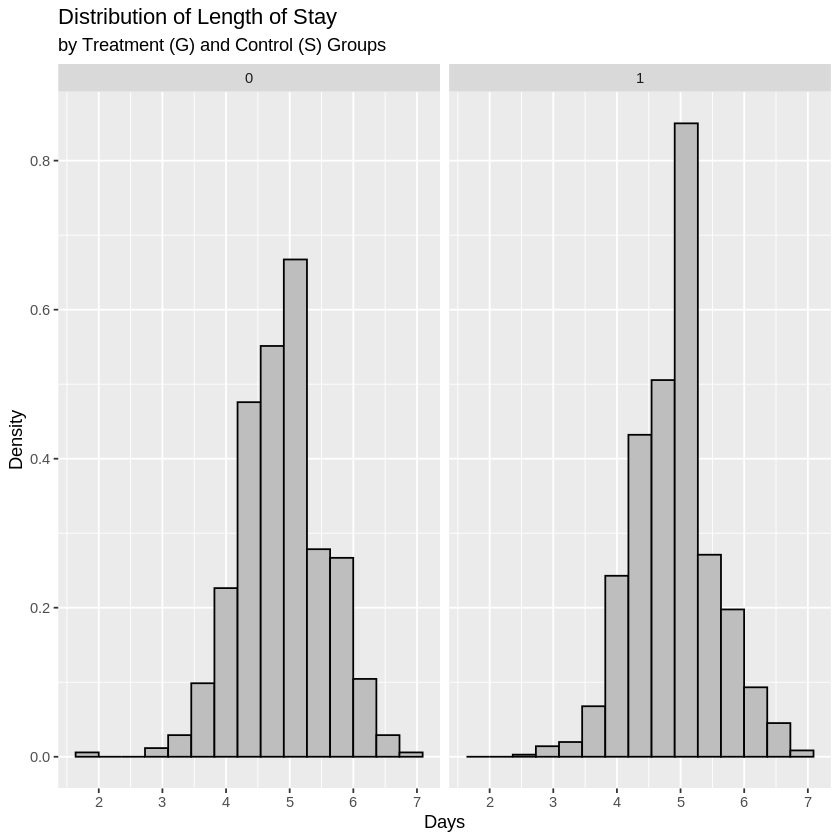

In [ ]:
ggplot(df) +
  geom_histogram(aes(x = len_of_stay, y = after_stat(density)),
                 bins = 15,
                 col = "black", fill = "grey") +
  facet_wrap(~ treatment, nrow = 1) +
  labs(title = "Distribution of Length of Stay",
       subtitle = "by Treatment (G) and Control (S) Groups",
       x = "Days",
       y = "Density")

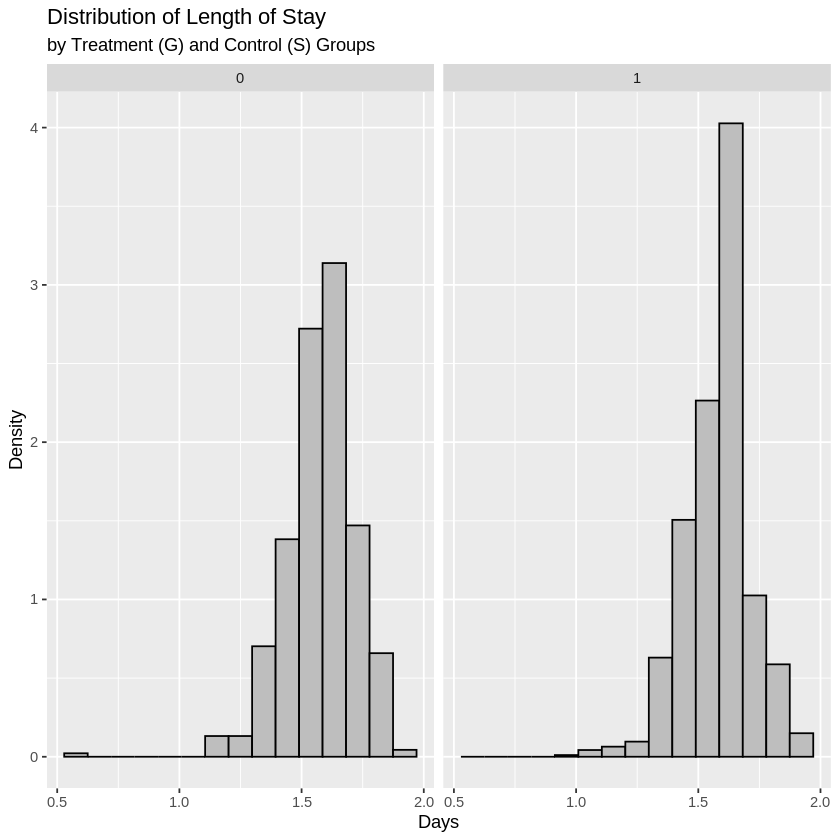

In [ ]:
ggplot(df) +
  geom_histogram(aes(x = log(len_of_stay), y = after_stat(density)),
                 bins = 15,
                 col = "black", fill = "grey") +
  facet_wrap(~ treatment, nrow = 1) +
  labs(title = "Distribution of Length of Stay",
       subtitle = "by Treatment (G) and Control (S) Groups",
       x = "Days",
       y = "Density")

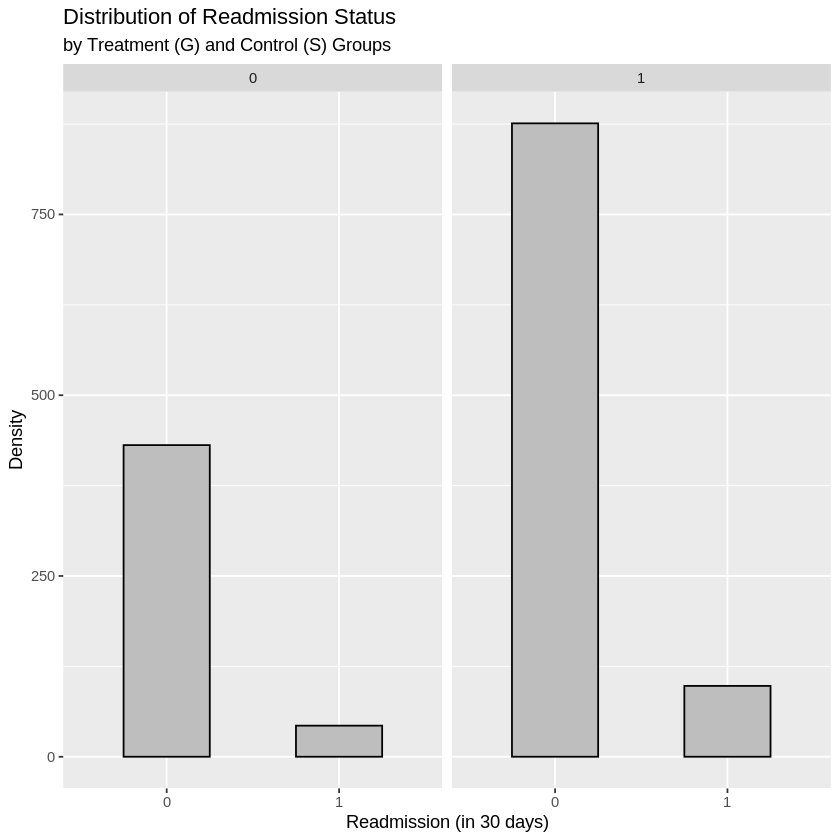

In [ ]:
ggplot(df) +
  geom_bar(aes(x = as.factor(readmitted)),
           width = 0.5,
           col = "black", fill = "grey") +
  facet_wrap(~ treatment, nrow = 1) +
  labs(title = "Distribution of Readmission Status",
       subtitle = "by Treatment (G) and Control (S) Groups",
       x = "Readmission (in 30 days)",
       y = "Density")

#### Correlation heatmap

In [ ]:
# number-code the dataframe
df_num_coded = df
for (col in categorical_cols) {
  df_num_coded[,col] = as.numeric(df_num_coded[,col])
}

# get the correlation matrix
corr_mat = cor(df_num_coded) %>% round(2)

# melt it
melted_corr_mat = as.data.frame(corr_mat) %>%
  rownames_to_column("var1") %>%
  pivot_longer(cols = -var1, names_to = "var2", values_to = "value")

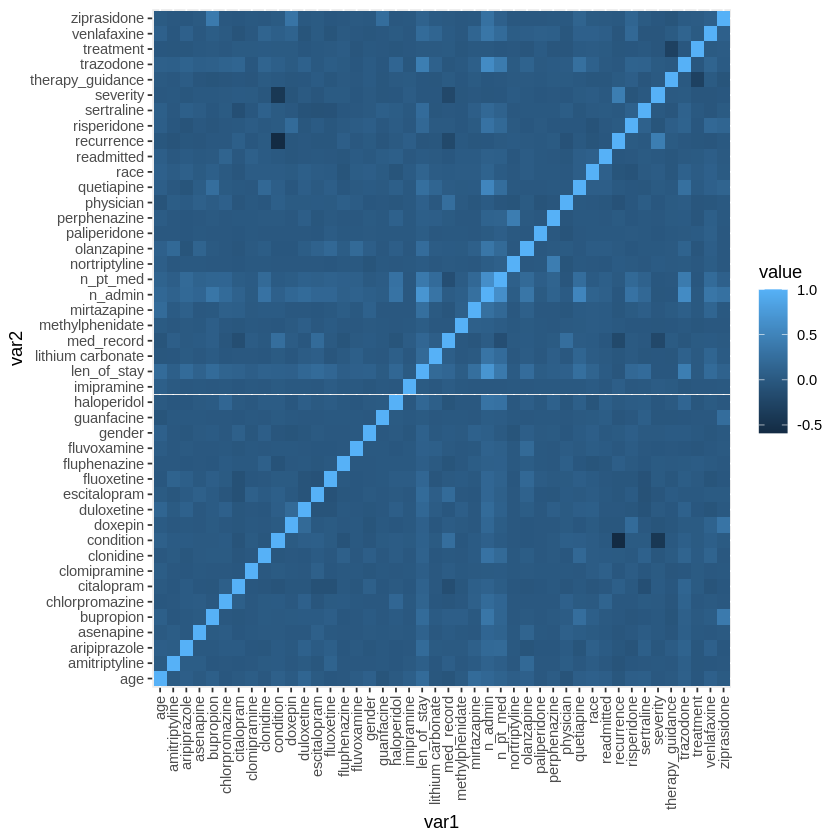

In [ ]:
ggplot(data = melted_corr_mat) +
  geom_tile(aes(x=var1, y=var2, fill=value)) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

### Length of Stay (LOS) variable transformation

Following the recommendation of the paper, we will get rid of observations for which length of stay (LOS) is unreasonably high (> 1000). We see that there are 11 observations that are dropped as a result.

We then take the recommendation of the paper to log transform LOS such that it follows a more normal distribution.

In [ ]:
(df$len_of_stay > 1000) %>% sum()

[1] 0

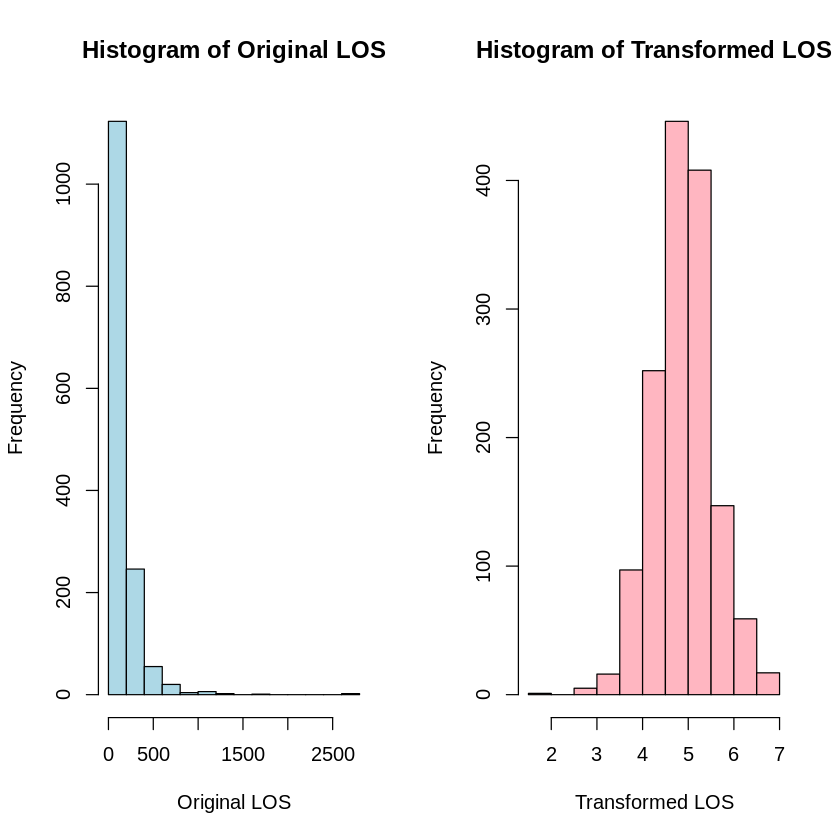

In [ ]:
old_df = df
df = df[df$len_of_stay <= 1000,]
df$len_of_stay = log(df$len_of_stay)

par(mfrow = c(1, 2))

hist(old_df$len_of_stay, main = "Histogram of Original LOS", xlab = "Original LOS", ylab = "Frequency", col = "lightblue")
hist(df$len_of_stay, main = "Histogram of Transformed LOS", xlab = "Transformed LOS", ylab = "Frequency", col = "lightpink")


## III. Fisher Randomization Test

First we will compute the simple "difference in means" for both outcome. We will use permutation and monte-carlo simulation to obtain p-values.

$H_0$: $Y_i(1) = Y_i(0)$ for all $i = 1, ..., n$, meaning the treatment has no effect.

$H_1$: The treatment does have an effect.

In [ ]:
set.seed(209)
responses = c('len_of_stay','readmitted')

for (response in responses){
  y = df[,response]
  print(paste("Calculations for", response))

  tau_hat = mean(y[df$treatment == 1])-mean(y[df$treatment == 0])
  print(paste("Tau hat:",tau_hat))

  MC = 10000

  tauhat_mc = rep(0,MC)

  for (mc in 1: MC)
  {
    z_perm = sample(df$treatment, replace=FALSE)
    tauhat_mc[mc] = mean(y[z_perm == 1]) - mean(y[z_perm == 0])}

  print(paste("p-value:",mean(tauhat_mc >= tau_hat)))
  print('---------------------')

}

[1] "Calculations for len_of_stay"
[1] "Tau hat: 0.0196337922229555"
[1] "p-value: 0.2976"
[1] "---------------------"
[1] "Calculations for readmitted"
[1] "Tau hat: 0.00989871684904566"
[1] "p-value: 0.3098"
[1] "---------------------"


Since the p-values for both response variables are greater than a significance level of 0.05, we fail to reject the null hypothesis that the treatment has no effect.

## IV. Neyman's Repeated Sampling Inference

Next, we will use Neymenian inference to determine if the average treatment effect is 0. We will obtain variance estimates and 95% confidence intervals.

$H_0$: $\frac{1}{n} \sum_{i=1}^{n}Y_i(1) - Y_i(0) = 0$

$H_1$: $\frac{1}{n} \sum_{i=1}^{n}Y_i(1) - Y_i(0) ≠ 0$

In [ ]:
responses = c('len_of_stay','readmitted')

for (response in responses){

  print(paste("Calculations for", response))
  #tau hat calculations
  y = df[,response]
  n_1 = nrow(df[which(df$treatment == 1),])
  n_0 = nrow(df[which(df$treatment == 0),])
  first_term = 1/n_1 * sum(as.numeric(as.character(y[df$treatment == 1])))
  second_term = 1/n_0 *sum(as.numeric(as.character(y[df$treatment == 0])))

  tau_hat = first_term - second_term

  print(paste("Tau hat:",tau_hat))

  #variance calculations
  y_bar1 = mean(as.numeric(as.character(y[df$treatment == 1])))
  y_bar0 = mean(as.numeric(as.character(y[df$treatment == 0])))
  s_1 = (1/(n_1-1))* (sum((as.numeric(as.character(y[df$treatment == 1]))- y_bar1)^2))
  s_0 = (1/(n_0-1))* (sum((as.numeric(as.character(y[df$treatment == 0]))- y_bar0)^2))

  v_hat = (1/n_1)*s_1 + (1/n_0)*s_0

  print(paste("Variance:",v_hat))

  #95% confidence interval
  upper_bound = tau_hat + 1.96*(v_hat^.5)
  lower_bound = tau_hat - 1.96*(v_hat^.5)
  print(paste("95% Confidence Interval:",lower_bound,",",upper_bound))
  print('---------------------')


}

[1] "Calculations for len_of_stay"
[1] "Tau hat: 0.0196337922229564"
[1] "Variance: 0.0013957467475976"
[1] "95% Confidence Interval: -0.0535912083272037 , 0.0928587927731164"
[1] "---------------------"
[1] "Calculations for readmitted"
[1] "Tau hat: 0.00989871684904567"
[1] "Variance: 0.000267396068345162"
[1] "95% Confidence Interval: -0.0221516924487273 , 0.0419491261468187"
[1] "---------------------"


## V. Variance Reduction Techniques

We will explore both post-stratification and regression adjustment.

### Post-Stratification

Now, we will assume that the data was collected as a stratified random experiment according to the following covariates: race, condition, and severity.

Using Neyman's null.

$H_0$: $\frac{1}{n} \sum_{i=1}^{n}Y_i(1) = Y_i(0) = 0$ for each stratum

$H_1$: $\frac{1}{n} \sum_{i=1}^{n}Y_i(1) - Y_i(0) ≠ 0$ across strata

#### Categorical Candidates

In [ ]:
#transforming trazodone into binary for stratification

df$trazodone_bin = ifelse(df$trazodone == 0, 0, 1)
df$trazodone_bin = as.factor(df$trazodone_bin)
head(df$trazodone_bin)

[1] 1 0 1 0 0 1
Levels: 0 1

In [ ]:
head(df$trazodone)

[1] 1 0 4 0 0 5

In [ ]:
df$n_pt_med_bin = ifelse(df$n_pt_med >=0 & df$n_pt_med <=2, 1, ifelse(df$n_pt_med >2 & df$n_pt_med <=5, 2, ifelse(df$n_pt_med>=6, 3, 0)))
df$n_pt_med_bin = as.factor(df$n_pt_med_bin)
head(df$n_pt_med_bin)

[1] 2 2 3 2 2 2
Levels: 1 2 3

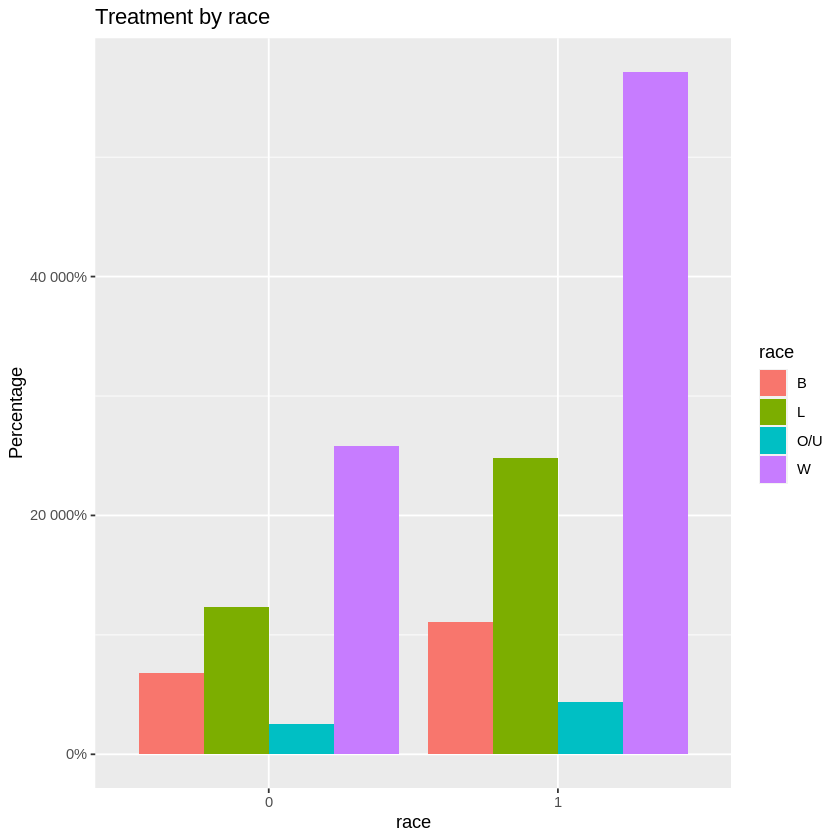

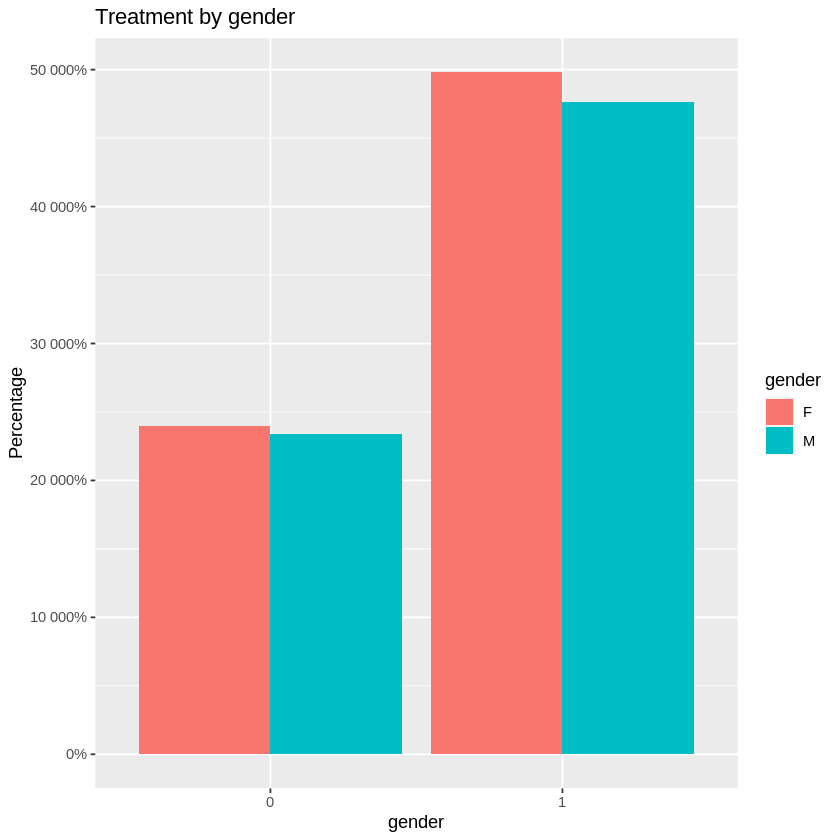

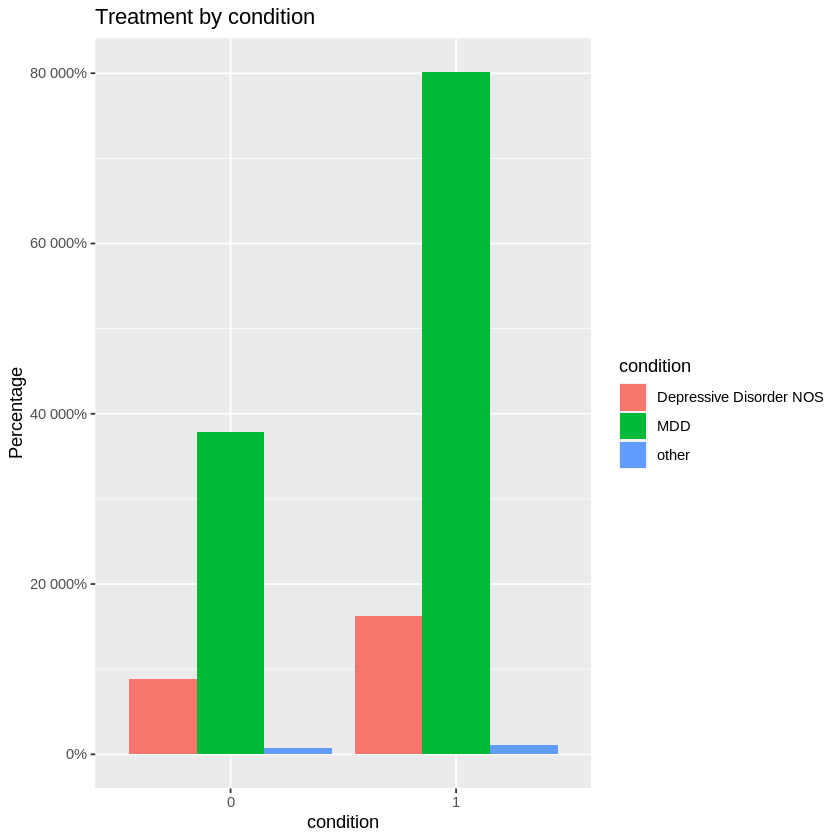

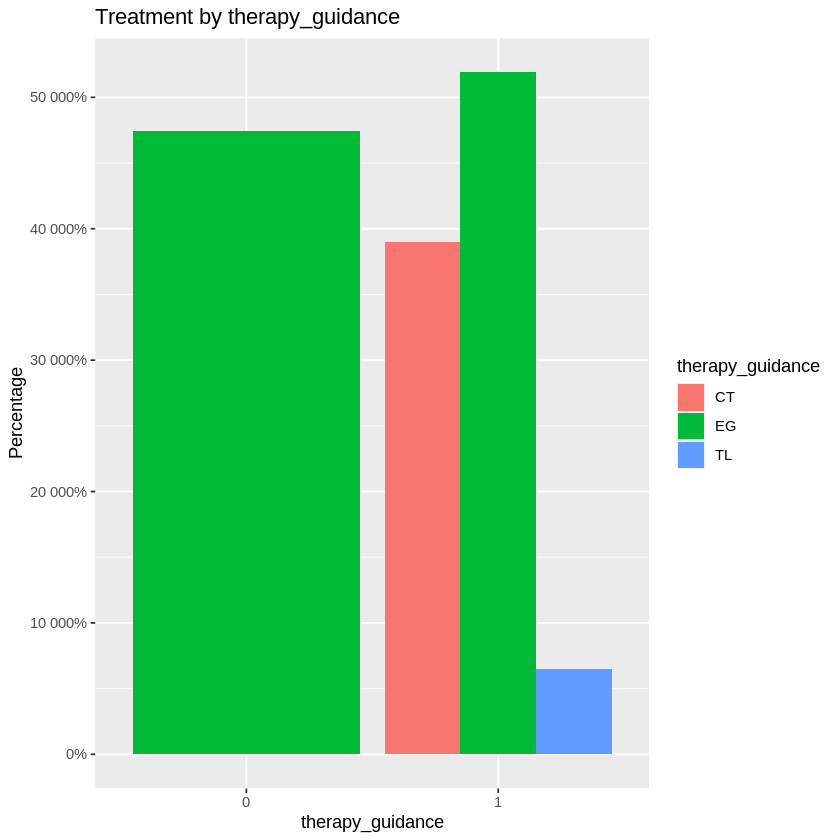

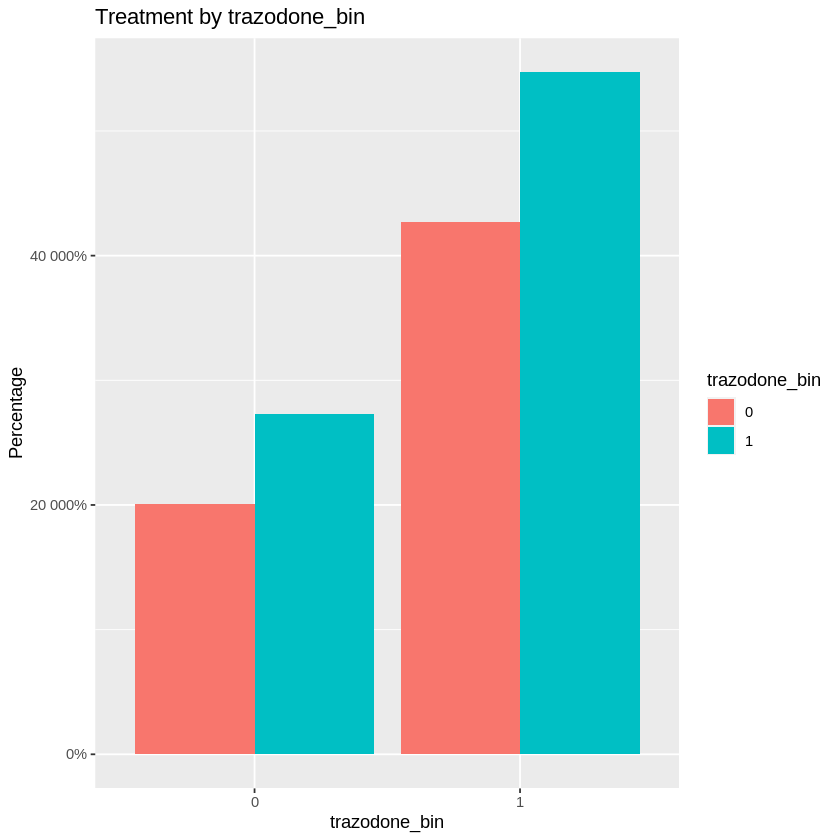

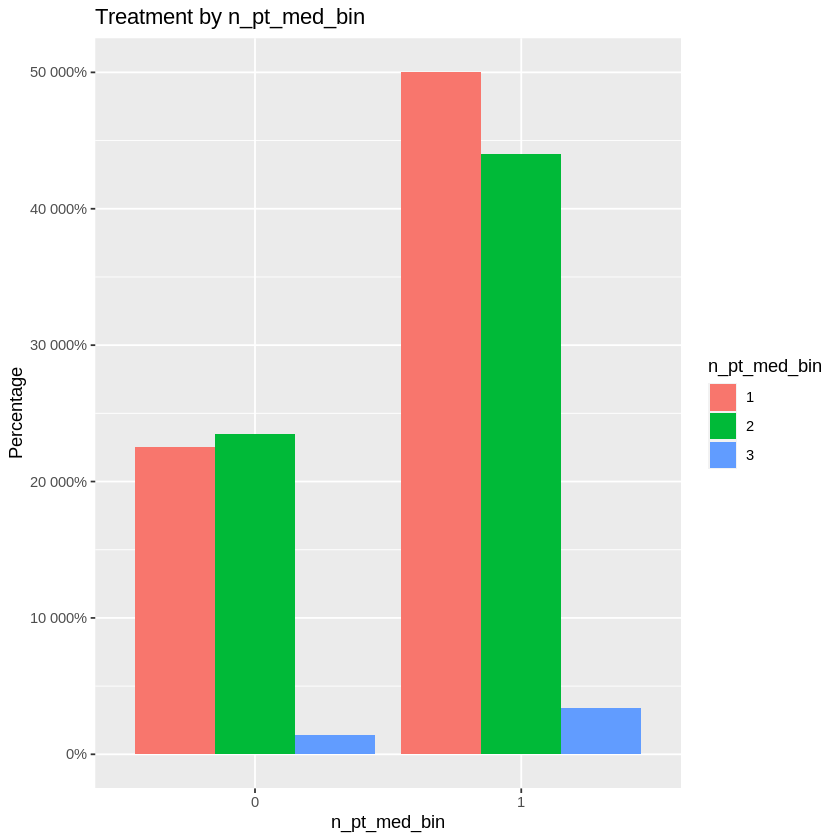

In [ ]:
candidates = c('race', 'gender', 'condition', 'therapy_guidance', 'trazodone_bin','n_pt_med_bin')
for (candidate in candidates) {
   print(ggplot(df) +
    geom_bar(aes_string(x = df$treatment, fill = candidate), position = "dodge") +
    xlab(candidate) + ylab("Percentage")+ scale_y_continuous(labels = scales::percent) +
    ggtitle(paste("Treatment by",candidate)))
}

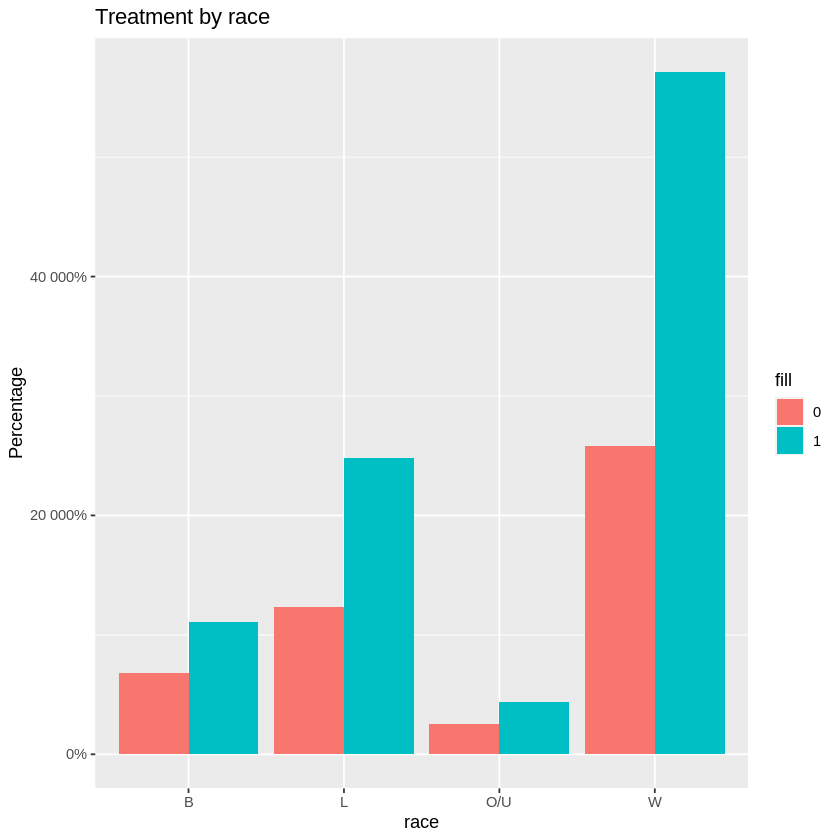

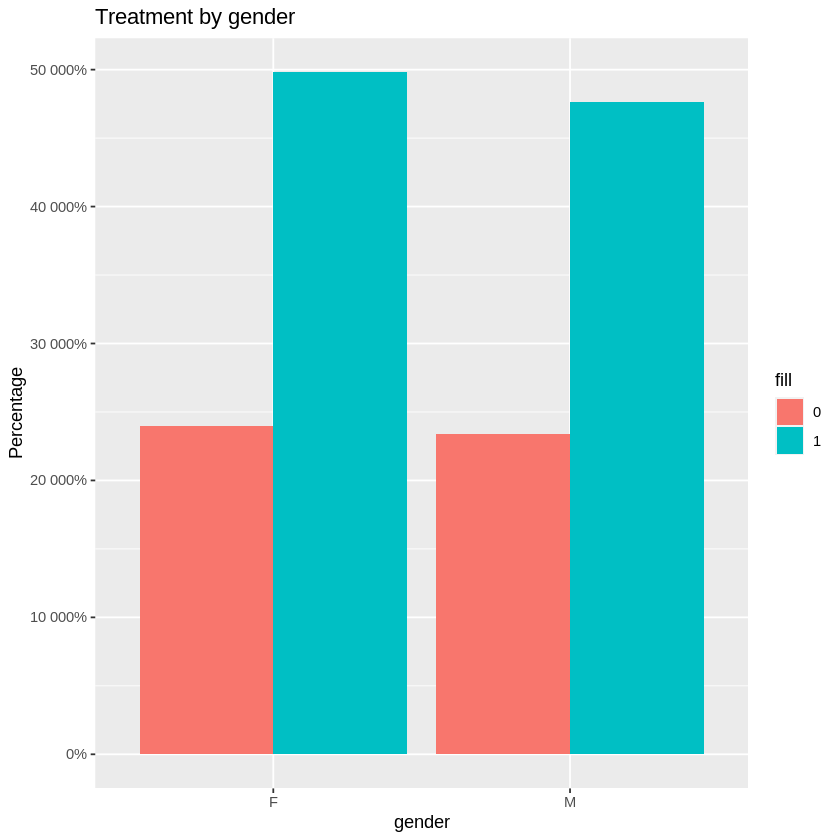

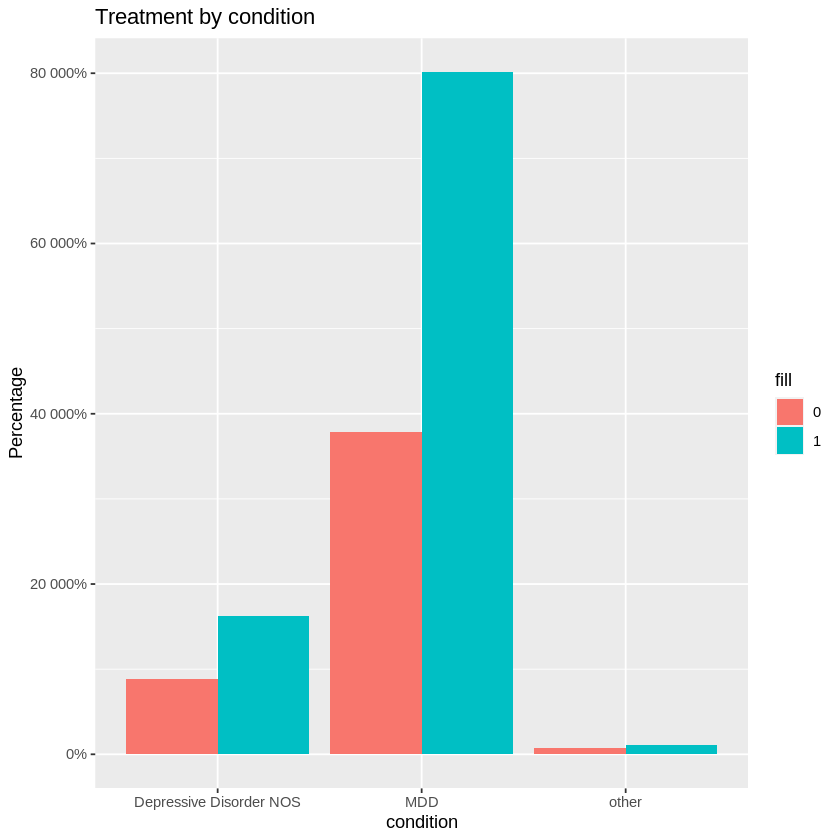

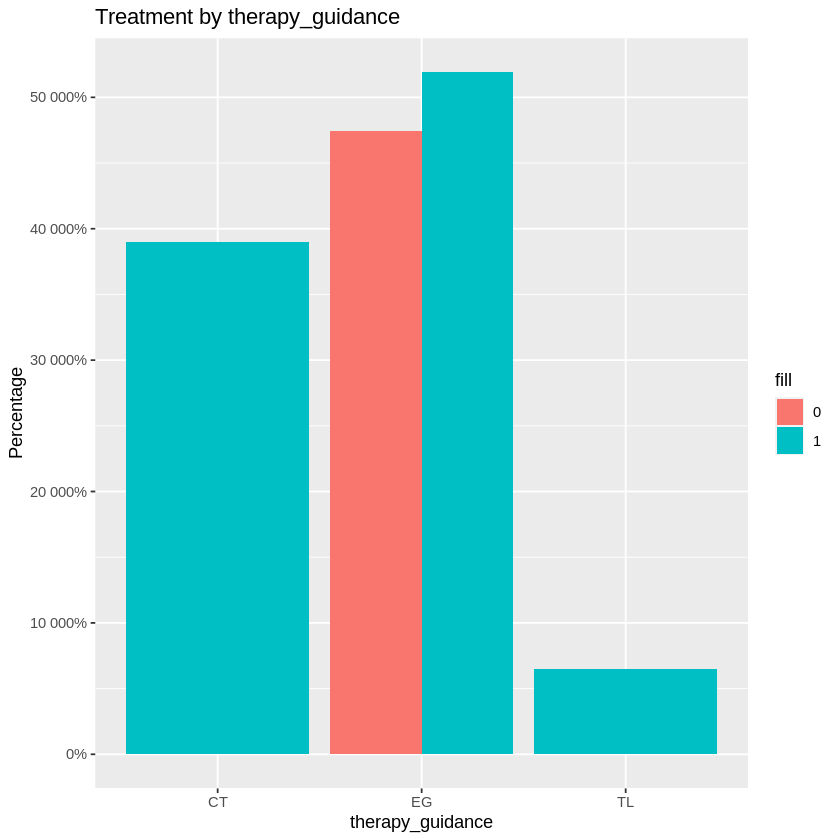

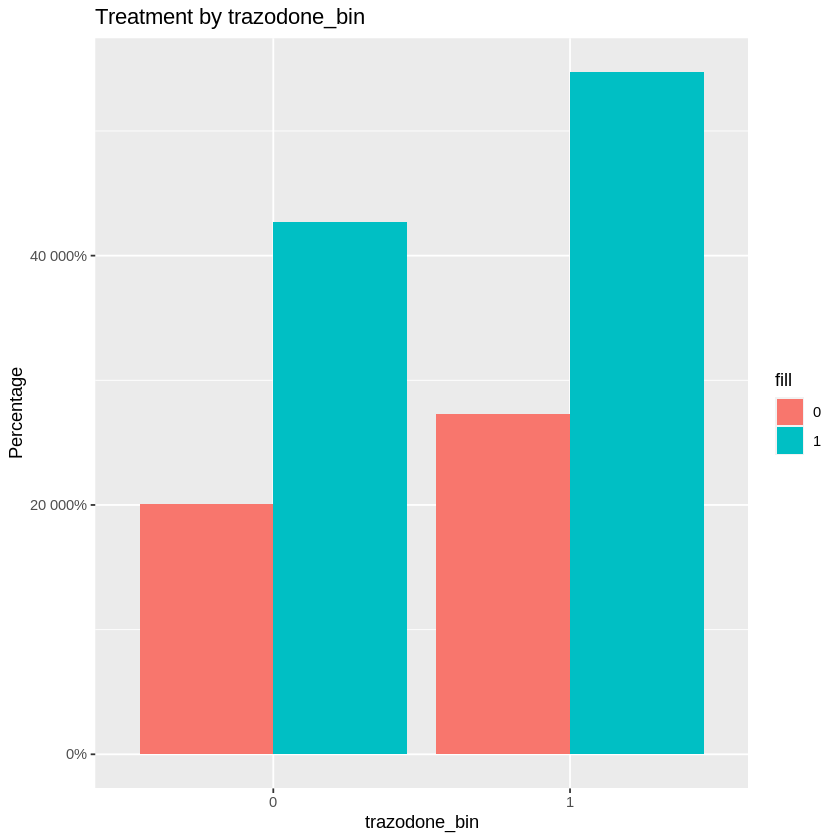

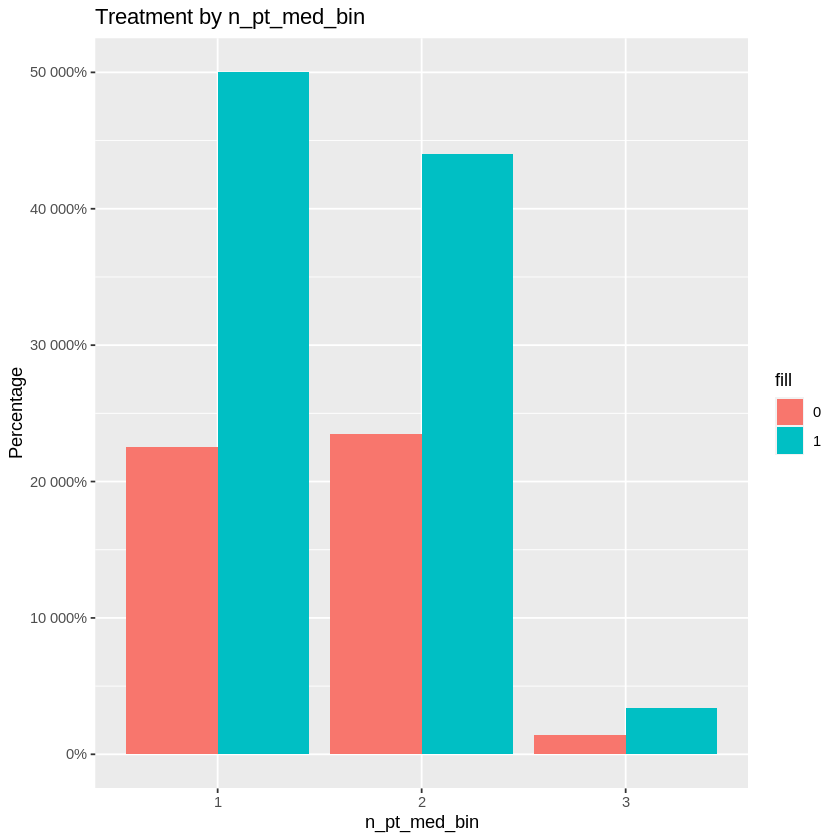

In [ ]:
candidates = c('race', 'gender', 'condition', 'therapy_guidance','trazodone_bin','n_pt_med_bin')
for (candidate in candidates) {
   print(ggplot(df) +
    geom_bar(aes_string(x = candidate, fill = df$treatment), position = "dodge") +
    xlab(candidate) + ylab("Percentage")+ scale_y_continuous(labels = scales::percent) +
    ggtitle(paste("Treatment by",candidate)))
}

#### Continuous Candidates

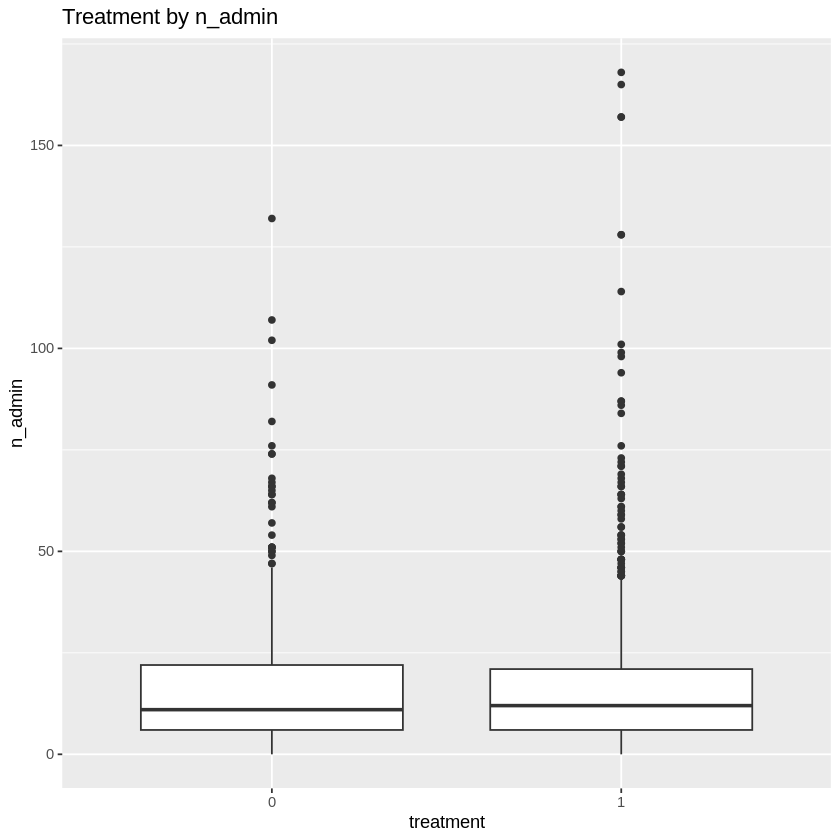

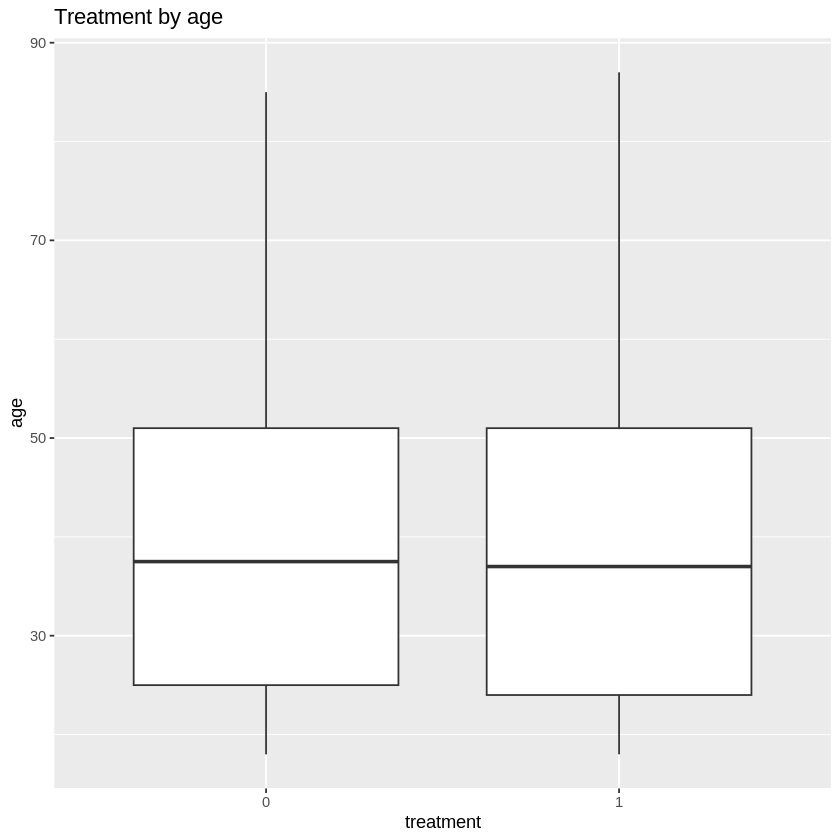

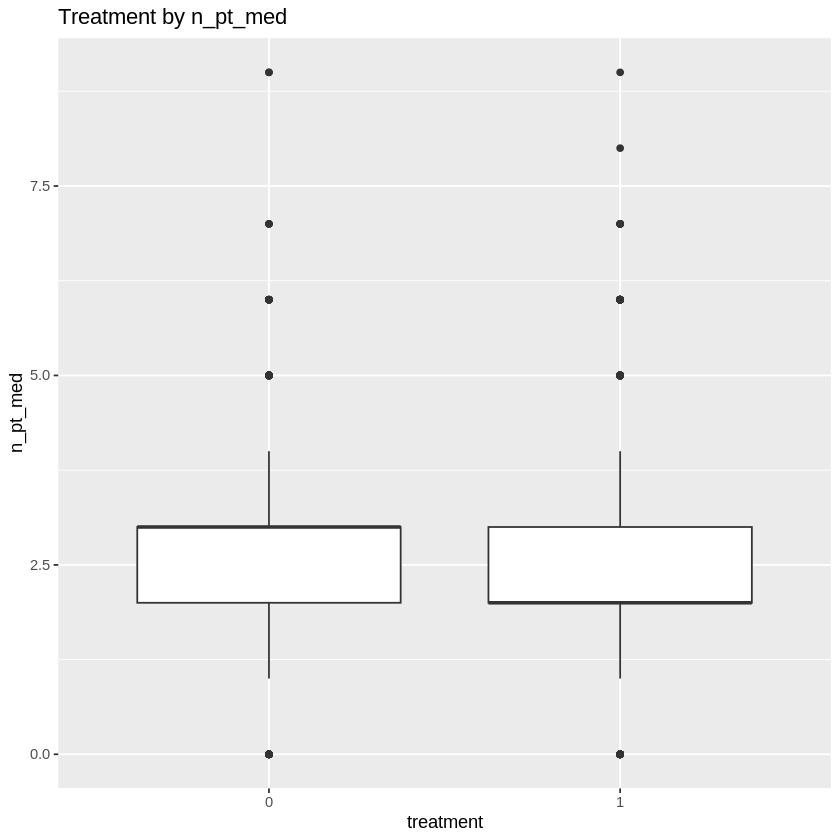

In [ ]:
candidates = c('n_admin', 'age','n_pt_med')

for (candidate in candidates) {
   print(ggplot(df, aes_string(x=df$treatment, y=candidate)) +
        geom_boxplot()+ggtitle(paste("Boxplots of",candidate,"by treatment")) +
    xlab('treatment') + ylab(candidate)+
    ggtitle(paste("Treatment by",candidate)))
}

In [ ]:
table(df$n_pt_med, df$treatment) #can't do it unless bin?

   
      0   1
  0  27  61
  1  56 129
  2 142 310
  3 135 231
  4  69 154
  5  31  55
  6   9  27
  7   3   5
  8   0   1
  9   2   1

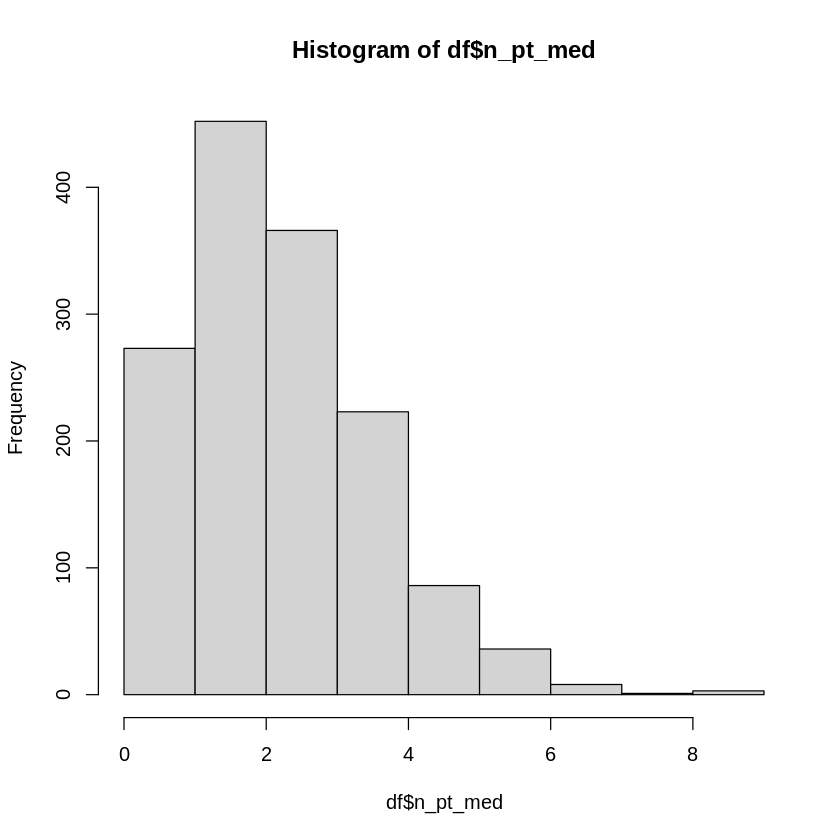

In [ ]:
hist(df$n_pt_med)

In [ ]:
table(df$n_pt_med_bin, df$treatment)

   
      0   1
  1 225 500
  2 235 440
  3  14  34

#### Stratification

In [ ]:
stratification = c('race','condition', 'trazodone_bin','n_pt_med_bin')
responses = c('len_of_stay','readmitted')

n = nrow(df)

#looping through each response and variable for stratification
for (response in responses) {
  for (var in stratification) {
      tau_is = list()
      var_is = list()
      categories = unique(df[,var])
      num_categories = length(categories)
      for (i in num_categories) {

        #calculations by strata
        df_cat = df[df[,var] == categories[i],]
        y = df_cat[,response]
        n_ki = nrow(df_cat)
        n_1 = nrow(df_cat[df_cat$treatment == 1,])
        n_0 = nrow(df_cat[df_cat$treatment == 0,])
        mean_G = mean(y[df_cat$treatment == 1])
        mean_S = mean(y[df_cat$treatment == 0])
        tau_i = mean_G-mean_S
        s1 = (1/(n_1-1)) * sum((y[df_cat$treatment == 1]-mean_G)^2)
        s0 = (1/(n_0-1)) * sum((y[df_cat$treatment == 0]-mean_S)^2)
        var_i = s1/n_1 + s0/n_0

        tau_ii = (n_ki/n) * tau_i
        var_ii = (n_ki^2/n^2) * var_i

        tau_is = append(tau_is, tau_ii)
        var_is = append(var_is, var_ii)

      }

    #calculating tau hat using terms calculated previously
    tau_hat = sum(unlist(tau_is))

    #calculating the estimated variance using terms calculated previously
    v_hat = sum(unlist(var_is))

    print(paste("Tau hat for",response,"stratifying by",var,"is:", tau_hat))
    print(paste("Variance estimate for",response,"stratifying by",var,"is:", v_hat))

    #95% confidence interval
    upper_bound = tau_hat + 1.96*(v_hat^.5)
    lower_bound = tau_hat - 1.96*(v_hat^.5)
    print(paste("95% Confidence Interval:",lower_bound,",",upper_bound))
    print('---------------------')
  }

}

[1] "Tau hat for len_of_stay stratifying by race is: -0.00382007737885621"
[1] "Variance estimate for len_of_stay stratifying by race is: 7.19013509955322e-05"
[1] "95% Confidence Interval: -0.0204398315883635 , 0.0127996768306511"
[1] "---------------------"
[1] "Tau hat for len_of_stay stratifying by condition is: -0.00520957363355876"
[1] "Variance estimate for len_of_stay stratifying by condition is: 1.51877926770052e-05"
[1] "95% Confidence Interval: -0.0128479912935184 , 0.00242884402640087"
[1] "---------------------"
[1] "Tau hat for len_of_stay stratifying by trazodone_bin is: 0.0403329653421884"
[1] "Variance estimate for len_of_stay stratifying by trazodone_bin is: 0.000671434842936369"
[1] "95% Confidence Interval: -0.0104546718604257 , 0.0911206025448025"
[1] "---------------------"
[1] "Tau hat for len_of_stay stratifying by n_pt_med_bin is: 0.0545642185022729"
[1] "Variance estimate for len_of_stay stratifying by n_pt_med_bin is: 0.000642771212761945"
[1] "95% Confidence

Recall these results for Neyman's null hypothesis without stratification:

For the response variable len_of_stay, tau hat = 5.903 and v hat = 82.416.
For the response variable readmitted, tau hat = 0.011 and v hat = 0.00026

The following table summarizes results:

| Variable | Response variable | Variance estimate | Variance reduction accomplished? |
|----------|:------------------|:--------------|:----------------------------------|
| race     | len_of_stay | 2.846 | yes |
| race | readmitted | 9.116e-06 | yes |
| condition | len_of_stay | 8.463 | yes |
| condition | readmitted | 1.178e-06 | yes |
| severity | len_of_stay | 0.345 | yes |
| severity | readmitted | 1.016e-06 | yes



Based on the results, stratifying by all 3 variables reduced the variance to the greatest degree for len_of_stay.

However, it is important to note that for each estimate of tau, the 95% confidence interval contains 0, which does not provide evidence against Neyman's null.

### Regression Adjustment

Next, we will try various regression adjustment techniques to reduce the variance of our estimator. They are:

1. Simple Linear Regression
2. Lin's Estimator
3. Random Forest (Regressor and Classifier)


We will evaluate these methods for both outcomes-- Length of Stay and Readmission


#### Feature selection with Elastic Net

Before implementing each of these methods, we will run elastic net regression in order to perform feature selection and reduce the number of features in our model. Then, we will include the selected covariates as well as the treatment in various regression-adjustment models.

In [ ]:
# number-code the categorical columns so next steps are easier
df_num_coded = df
for (col in categorical_cols) {
  df_num_coded[,col] = as.numeric(df_num_coded[,col])
}

# get the correlation matrix
corr_mat = cor(df_num_coded) %>% round(2)

# melt it
melted_corr_mat = as.data.frame(corr_mat) %>%
  rownames_to_column("var1") %>%
  pivot_longer(cols = -var1, names_to = "var2", values_to = "value")

df_num_coded[, categorical_cols] = lapply(df_num_coded[, categorical_cols], factor)


In [ ]:
# function to perform elastic net regression given specified alpha
# also formats data correctly for regression

create_df <- function(data, df_num_coded, response, alpha) {
  data$treatment <- as.numeric(data$treatment) - 1

    features = setdiff(names(df_num_coded), c("len_of_stay", "readmitted", "treatment"))
    X = as.matrix(df_num_coded[, features])
    y = df_num_coded[[response]]

    if (response == 'len_of_stay') {
      elnet_model = cv.glmnet(X, y, alpha = alpha, intercept = FALSE)  # alpha = 1 corresponds to Lasso
      nonzero_features = c("intercept", colnames(X))[as.numeric(coef(elnet_model)) != 0]
      print(length(nonzero_features))
      print(nonzero_features)
      X_elnet = X[,nonzero_features] %>% data.frame()
      for (col in colnames(X_elnet)) {
          if (col %in% c("race", "med_record", "condition", "severity", "recurrence", "therapy_guidance",
          "physician", "gender")) {
              X_elnet[, col] = X_elnet[, col] %>% as.factor()
          } else {
            X_elnet[, col] = X_elnet[, col] %>% as.numeric()
        }
      }
      df_elnet = data %>% select("treatment", "len_of_stay", "readmitted") %>% cbind(X_elnet)
      return (df_elnet)
    }


    if (response == 'readmitted') {
      elnet_model = cv.glmnet(X, y, alpha = alpha, family = "binomial", intercept = FALSE)
      nonzero_features = c("intercept", colnames(X))[as.numeric(coef(elnet_model)) != 0]
      print(length(nonzero_features))
      print(nonzero_features)
      X_elnet = X[,nonzero_features] %>% data.frame()
      for (col in colnames(X_elnet)) {
          if (col %in% c("race", "med_record", "condition", "severity", "recurrence", "therapy_guidance",
          "physician", "gender")) {
              X_elnet[, col] = X_elnet[, col] %>% as.factor()
          } else {
            X_elnet[, col] = X_elnet[, col] %>% as.numeric()
        }
      }
      df_elnet = data %>% select("treatment", "len_of_stay", "readmitted") %>% cbind(X_elnet)
      return (df_elnet)
    }

    return(data)
  }


In [ ]:
# create all of the df's that we will evaluate methods on
set.seed(209)
reg_los <- c(1, 0.02)
reg_readmit <- c(0.007, 0.005)

df_elnet_LOS_small = create_df(df, df_num_coded, 'len_of_stay', 1)
df_elnet_LOS_big = create_df(df, df_num_coded, 'len_of_stay', 0.02)


[1] 15
 [1] "gender"           "age"              "race"             "physician"       
 [5] "med_record"       "n_pt_med"         "n_admin"          "therapy_guidance"
 [9] "aripiprazole"     "citalopram"       "fluoxetine"       "sertraline"      
[13] "condition"        "recurrence"       "severity"        
[1] 19
 [1] "gender"            "age"               "race"             
 [4] "physician"         "med_record"        "n_pt_med"         
 [7] "n_admin"           "therapy_guidance"  "aripiprazole"     
[10] "citalopram"        "escitalopram"      "fluoxetine"       
[13] "lithium carbonate" "mirtazapine"       "sertraline"       
[16] "trazodone"         "condition"         "recurrence"       
[19] "severity"         


In [ ]:
set.seed(20)
df_elnet_RAR_small = create_df(df, df_num_coded, 'readmitted', 0.01)
df_elnet_RAR_big = create_df(df, df_num_coded, 'readmitted', 0.005)


[1] 12
 [1] "gender"           "age"              "race"             "physician"       
 [5] "med_record"       "n_pt_med"         "therapy_guidance" "chlorpromazine"  
 [9] "trazodone"        "condition"        "recurrence"       "severity"        
[1] 20
 [1] "gender"           "age"              "race"             "physician"       
 [5] "med_record"       "n_pt_med"         "n_admin"          "therapy_guidance"
 [9] "chlorpromazine"   "citalopram"       "clomipramine"     "duloxetine"      
[13] "escitalopram"     "fluoxetine"       "guanfacine"       "risperidone"     
[17] "trazodone"        "condition"        "recurrence"       "severity"        




---



#### FRT with Covariates

First, we will run simple linear regression where we regress our outcome on the treatment indicator and the covariates selected from each elastic net regression.




In [ ]:
get_estimate_for_simple_reg = function(data, response) {

  if (response == "len_of_stay") {
    fit = lm(len_of_stay ~ . - 1, data = data %>% select(-c("readmitted")))
    tau_hat = summary(fit)$coefficients["treatment", "Estimate"]
    cat(paste("Tau hat for", response, "is", round(tau_hat, 5)))
    # get p_value
    cat("\n")
    p_value = summary(fit)$coefficients["treatment", "Pr(>|t|)"]
    cat(paste("p-value: ", round(p_value, 3)))
  }
  if (response == "readmitted") {
    fit = lm(readmitted ~ . - 1, data = data %>% select(-c("len_of_stay")))
    tau_hat = summary(fit)$coefficients["treatment", "Estimate"]
    cat(paste("Tau hat for", response, "is", round(tau_hat, 5)))
    # get p_value
    cat("\n")
    p_value = summary(fit)$coefficients["treatment", "Pr(>|t|)"]
    cat(paste("p-value: ", round(p_value, 5)))
  }

}

##### Length of Stay

In [ ]:
print("Results for alpha = 1")
get_estimate_for_simple_reg(df_elnet_LOS_small, "len_of_stay")
cat("\n")
print("------------------------------------------")
print("Results for alpha = 0.02")
get_estimate_for_simple_reg(df_elnet_LOS_big, "len_of_stay")

[1] "Results for alpha = 1"
Tau hat for len_of_stay is 0.031
p-value:  0.271
[1] "------------------------------------------"
[1] "Results for alpha = 0.02"
Tau hat for len_of_stay is 0.027
p-value:  0.326

##### Readmission

In [ ]:
print("Results for alpha = 0.01")
get_estimate_for_simple_reg(df_elnet_RAR_small, "readmitted")
cat("\n")
print("------------------------------------------")
print("Results for alpha = 0.005")
get_estimate_for_simple_reg(df_elnet_RAR_big, "readmitted")

[1] "Results for alpha = 0.01"
Tau hat for readmitted is 0.00051
p-value:  0.97845
[1] "------------------------------------------"
[1] "Results for alpha = 0.05"
Tau hat for readmitted is 0.00036
p-value:  0.98452

#### Lin's Estimator

Lin's estimator centers covariates and performs a regression of the form Y ~ Z + X + Z * X. We can obtain confidence intervals and estimates of variance from Lin's Estimator.

In [ ]:
prepare_X_for_lin = function(data) {
  X = data %>% select(-c("len_of_stay", "readmitted", "treatment"))
  # one-hot encode X
  dum = dummyVars(" ~ .", data = X)
  X_ohe = data.frame(predict(dum, newdata = X))
  # standardize X
  scaled_X_ohe = scale(X_ohe, center = TRUE, scale = FALSE) %>%
    data.matrix()


  scaled_X_ohe
}


get_lin_s_estimator = function(data, response) {
  X = prepare_X_for_lin(data)
  Z = data$treatment
  Y = data[, response]

  fit_robust = lm_robust(Y ~ Z + X + Z*X)
  # tau_hat
  tau_hat = fit_robust$coefficients["Z"] %>% as.numeric()
  # p value
  std_err = fit_robust$std.error["Z"] %>% as.numeric()

  cat(paste("Tau hat for", response, "is", round(tau_hat, 3)))
  cat("\n")

  cat(paste("Variance", response, "is", round(std_err^2, 5)))
  cat("\n")

  cat(paste("The 95% confidence interval for tau hat is (",
            round(tau_hat - 1.96 * std_err, 3),
            ", ",
            round(tau_hat + 1.96 * std_err, 3),
            ")", sep = ""))
}


##### Length of Stay

In [ ]:
print("Results for alpha = 1")
get_lin_s_estimator(df_elnet_LOS_small, "len_of_stay")
cat("\n")
print("---------------------------")
print("Results for alpha = 0.02")
get_lin_s_estimator(df_elnet_LOS_big, "len_of_stay")

[1] "Results for alpha = 1"
Tau hat for len_of_stay is 0.031
Variance len_of_stay is 0.00078
The 95% confidence interval for tau hat is (-0.024, 0.086)
[1] "---------------------------"
[1] "Results for alpha = 0.02"
Tau hat for len_of_stay is 0.029
Variance len_of_stay is 0.00096
The 95% confidence interval for tau hat is (-0.031, 0.09)

##### Readmission

In [ ]:
print("Results for alpha = 0.01")
get_lin_s_estimator(df_elnet_RAR_small, "readmitted")
cat("\n")
print("---------------------------")
print("Results for alpha = 0.005")
get_lin_s_estimator(df_elnet_RAR_big, "readmitted")

[1] "Results for alpha = 0.01"
Tau hat for readmitted is 0.003
Variance readmitted is 0.00033
The 95% confidence interval for tau hat is (-0.032, 0.039)
[1] "---------------------------"
[1] "Results for alpha = 0.005"
Tau hat for readmitted is 0.004
Variance readmitted is 0.00033
The 95% confidence interval for tau hat is (-0.031, 0.04)

#### Generalized Lin's Estimator -- Random Forest


We will utilize random forest with cross fitting and appropriate variance estimation (formula given in class notes)

##### Length of Stay

In [ ]:
set.seed(209)

# note: adapting this funciton from HW 2 solutions
get_tau_hat_v_hat_crossfitted_LOS <- function(data, Z) {
  Y <- data[, 'len_of_stay']
  n <- length(Z)

  columns_to_exclude <- c("len_of_stay", "readmitted", "treatment")
  variables_to_include <- colnames(data)[!colnames(data) %in% columns_to_exclude]
  data_subset <- data[variables_to_include]
  X <- model.matrix(~ ., data = data_subset)[, -1]


  shuffled_indices <- sample(seq_len(n))
  split <- floor(n / 2)
  I_1_indices <- shuffled_indices[seq_len(split)]
  I_2_indices <- shuffled_indices[seq(from = split + 1, to = n, by = 1)]
  I_groups <- list(
    "I1" = list(
    "Y" = Y[I_1_indices],
    "Z" = Z[I_1_indices],
    "X" = X[I_1_indices, ],
    "indices" = I_1_indices),

    "I2" = list(
    "Y" = Y[I_2_indices],
    "Z" = Z[I_2_indices],
    "X" = X[I_2_indices, ],
    "indices" = I_2_indices
        )
   )
  for (i in names(I_groups)) {
    I_i <- I_groups[[i]]
    Y_subset <- I_i$Y
    Z_subset <- I_i$Z
    X_subset <- I_i$X
    X_subset_centered <- scale(X_subset, center = TRUE, scale = FALSE)
    n_i1 <- sum(Z_subset == 1)
    I_groups[[i]][["n1"]] <- n_i1
    n_i0 <- sum(Z_subset == 0)
    I_groups[[i]][["n0"]] <- n_i0
    I_groups[[i]][["n"]] <- n_i1 + n_i0

df_i <- cbind(Y_subset, data.frame(X_subset_centered))
mu_hat_1_rf <- randomForest(Y_subset ~ ., data = df_i[Z_subset == 1, ])
# Center full data frame based on training centering process
X_full_centered <- X - matrix(
rep(attr(X_subset_centered, "scaled:center"), nrow(X)),
ncol = ncol(X),
byrow = TRUE
)
df_full <- cbind(Y, data.frame(X_full_centered))
I_groups[[i]][["mu_tilde_1"]] <- predict(mu_hat_1_rf, newdata = df_full) + (
(1 / n_i1) * sum(
Y_subset[Z_subset == 1] -
predict(mu_hat_1_rf, newdata = df_i[Z_subset == 1, ])
)
)
mu_hat_0_rf <- randomForest(Y_subset ~ ., data = df_i[Z_subset == 0, ])
I_groups[[i]][["mu_tilde_0"]] <- predict(mu_hat_0_rf, newdata = df_full) + (
(1 / n_i0) * sum(
Y_subset[Z_subset == 0] -
predict(mu_hat_0_rf, newdata = df_i[Z_subset == 0, ])
)
)
}
for (i in names(I_groups)) {
I_i <- I_groups[[i]]
indices <- I_i$indices
other <- names(I_groups)[names(I_groups) != i]
I_other <- I_groups[[other]]
I_groups[[i]][["tau_hat"]] <- (
(1 / I_i$n) * (
sum(I_i$Y[I_i$Z == 1]) + sum(I_other$mu_tilde_1[indices][I_i$Z == 0])
) -
(1 / I_i$n) * (
sum(I_i$Y[I_i$Z == 0]) + sum(I_other$mu_tilde_0[indices][I_i$Z == 1])
)
)
}
tau_hat <- (
(I_groups$I1$n / n) * I_groups$I1$tau_hat +
(I_groups$I2$n / n) * I_groups$I2$tau_hat
)
V_hat_I <- list()
for (i in names(I_groups)) {
I_i <- I_groups[[i]]
other <- names(I_groups)[names(I_groups) != i]
I_other <- I_groups[[other]]
sigma_hat_I_2_1 <- (1 / (I_i$n1 - 1)) * sum(
(I_i$Y[I_i$Z == 1] - I_other$mu_tilde_1[I_i$indices][I_i$Z == 1])^2
)
sigma_hat_I_2_0 <- (1 / (I_i$n0 - 1)) * sum(
(I_i$Y[I_i$Z == 0] - I_other$mu_tilde_0[I_i$indices][I_i$Z == 0])^2
)
sigma_hat_I_2_tau <- (1 / (I_i$n - 1)) * sum(
(
I_other$mu_tilde_1[I_i$indices] -
I_other$mu_tilde_0[I_i$indices] -
mean(I_other$mu_tilde_1[I_i$indices]) +
mean(I_other$mu_tilde_0[I_i$indices])
)^2
)
I_groups[[i]][["V_hat"]] <- (
(1 / I_i$n1) * sigma_hat_I_2_1 +
(1 / I_i$n0) * sigma_hat_I_2_0 +
(1 / I_i$n) * sigma_hat_I_2_tau
)
}
V_hat <- (
(I_groups$I1$n / n)^2 * I_groups$I1$V_hat +
(I_groups$I2$n / n)^2 * I_groups$I2$V_hat
)


results <- c("tau_hat" = tau_hat, "V_hat" = V_hat)

# Calculate standard error (square root of variance estimate)
SE <- sqrt(V_hat)


# Calculate the margin of error (z-value for 95% CI * standard error)
margin_error <- 1.96 * SE  # for 95% CI (two-tailed)

# Calculate lower and upper bounds of the confidence interval
lower_bound <- tau_hat - margin_error
upper_bound <- tau_hat + margin_error

# Display the confidence interval
cat("95% Confidence Interval for tau_hat:", lower_bound, "to", upper_bound, "\n")


return(results)
}


In [ ]:
set.seed(209)
get_tau_hat_v_hat_crossfitted_LOS(df_elnet_LOS_small, df_elnet_LOS_small$treatment)
print("\n")
print("---------------------------")
get_tau_hat_v_hat_crossfitted_LOS(df_elnet_LOS_big, df_elnet_LOS_big$treatment)



95% Confidence Interval for tau_hat: -0.02639496 to 0.06449012 


tau_hat        V_hat 
0.0190475776 0.0005375428

[1] "\n"
[1] "---------------------------"
95% Confidence Interval for tau_hat: -0.01044333 to 0.07531388 


tau_hat        V_hat 
0.0324352725 0.0004785961

##### Readmission

In [ ]:
set.seed(209)

# note: adapting this funciton from HW 2 solutions
get_tau_hat_v_hat_crossfitted_readmit <- function(data) {
  Y <- data[, 'readmitted']
  n <- length(Z)

  columns_to_exclude <- c("len_of_stay", "readmitted", "treatment")
  variables_to_include <- colnames(data)[!colnames(data) %in% columns_to_exclude]
  data_subset <- data[variables_to_include]
  X <- model.matrix(~ ., data = data_subset)[, -1]


  shuffled_indices <- sample(seq_len(n))
  split <- floor(n / 2)
  I_1_indices <- shuffled_indices[seq_len(split)]
  I_2_indices <- shuffled_indices[seq(from = split + 1, to = n, by = 1)]
  I_groups <- list(
    "I1" = list(
    "Y" = Y[I_1_indices],
    "Z" = Z[I_1_indices],
    "X" = X[I_1_indices, ],
    "indices" = I_1_indices),

    "I2" = list(
    "Y" = Y[I_2_indices],
    "Z" = Z[I_2_indices],
    "X" = X[I_2_indices, ],
    "indices" = I_2_indices
        )
   )
  for (i in names(I_groups)) {
    I_i <- I_groups[[i]]
    Y_subset <- I_i$Y
    Z_subset <- I_i$Z
    X_subset <- I_i$X
    X_subset_centered <- scale(X_subset, center = TRUE, scale = FALSE)
    n_i1 <- sum(Z_subset == 1)
    I_groups[[i]][["n1"]] <- n_i1
    n_i0 <- sum(Z_subset == 0)
    I_groups[[i]][["n0"]] <- n_i0
    I_groups[[i]][["n"]] <- n_i1 + n_i0

df_i <- cbind(Y_subset, data.frame(X_subset_centered))
mu_hat_1_rf <- randomForest(Y_subset ~ ., data = df_i[Z_subset == 1, ])
# Center full data frame based on training centering process
X_full_centered <- X - matrix(
rep(attr(X_subset_centered, "scaled:center"), nrow(X)),
ncol = ncol(X),
byrow = TRUE
)
df_full <- cbind(Y, data.frame(X_full_centered))
I_groups[[i]][["mu_tilde_1"]] <- predict(mu_hat_1_rf, newdata = df_full) + (
(1 / n_i1) * sum(
Y_subset[Z_subset == 1] -
predict(mu_hat_1_rf, newdata = df_i[Z_subset == 1, ])
)
)
mu_hat_0_rf <- randomForest(Y_subset ~ ., data = df_i[Z_subset == 0, ])
I_groups[[i]][["mu_tilde_0"]] <- predict(mu_hat_0_rf, newdata = df_full) + (
(1 / n_i0) * sum(
Y_subset[Z_subset == 0] -
predict(mu_hat_0_rf, newdata = df_i[Z_subset == 0, ])
)
)
}
for (i in names(I_groups)) {
I_i <- I_groups[[i]]
indices <- I_i$indices
other <- names(I_groups)[names(I_groups) != i]
I_other <- I_groups[[other]]
I_groups[[i]][["tau_hat"]] <- (
(1 / I_i$n) * (
sum(I_i$Y[I_i$Z == 1]) + sum(I_other$mu_tilde_1[indices][I_i$Z == 0])
) -
(1 / I_i$n) * (
sum(I_i$Y[I_i$Z == 0]) + sum(I_other$mu_tilde_0[indices][I_i$Z == 1])
)
)
}
tau_hat <- (
(I_groups$I1$n / n) * I_groups$I1$tau_hat +
(I_groups$I2$n / n) * I_groups$I2$tau_hat
)
V_hat_I <- list()
for (i in names(I_groups)) {
I_i <- I_groups[[i]]
other <- names(I_groups)[names(I_groups) != i]
I_other <- I_groups[[other]]
sigma_hat_I_2_1 <- (1 / (I_i$n1 - 1)) * sum(
(I_i$Y[I_i$Z == 1] - I_other$mu_tilde_1[I_i$indices][I_i$Z == 1])^2
)
sigma_hat_I_2_0 <- (1 / (I_i$n0 - 1)) * sum(
(I_i$Y[I_i$Z == 0] - I_other$mu_tilde_0[I_i$indices][I_i$Z == 0])^2
)
sigma_hat_I_2_tau <- (1 / (I_i$n - 1)) * sum(
(
I_other$mu_tilde_1[I_i$indices] -
I_other$mu_tilde_0[I_i$indices] -
mean(I_other$mu_tilde_1[I_i$indices]) +
mean(I_other$mu_tilde_0[I_i$indices])
)^2
)
I_groups[[i]][["V_hat"]] <- (
(1 / I_i$n1) * sigma_hat_I_2_1 +
(1 / I_i$n0) * sigma_hat_I_2_0 +
(1 / I_i$n) * sigma_hat_I_2_tau
)
}
V_hat <- (
(I_groups$I1$n / n)^2 * I_groups$I1$V_hat +
(I_groups$I2$n / n)^2 * I_groups$I2$V_hat
)


results <- c("tau_hat" = tau_hat, "V_hat" = V_hat)

# Calculate standard error (square root of variance estimate)
SE <- sqrt(V_hat)


# Calculate the margin of error (z-value for 95% CI * standard error)
margin_error <- 1.96 * SE  # for 95% CI (two-tailed)

# Calculate lower and upper bounds of the confidence interval
lower_bound <- tau_hat - margin_error
upper_bound <- tau_hat + margin_error

# Display the confidence interval
cat("95% Confidence Interval for tau_hat:", lower_bound, "to", upper_bound, "\n")


return(results)
}


In [ ]:
set.seed(20)
get_tau_hat_v_hat_crossfitted_readmit(df_elnet_RAR_small, df_elnet_RAR_small$treatment)
print("\n")
print("---------------------------")
get_tau_hat_v_hat_crossfitted_readmit(df_elnet_RAR_big, df_elnet_RAR_big$treatment)



Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


95% Confidence Interval for tau_hat: -0.02913237 to 0.04031039 


tau_hat        V_hat 
0.0055890133 0.0003138208

[1] "\n"
[1] "---------------------------"


Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


95% Confidence Interval for tau_hat: -0.02651557 to 0.04163685 


tau_hat        V_hat 
0.0075606411 0.0003022668

## VI. Sensitivity Plots

We will visualize how sensitive our various regression-adjustmnt methods are to the input features, by changing the regularization parameter in elastic net to select a larger number of features. We plot the estimates and confidence intervals for each set of features and each method.

### Length of Stay

In [ ]:
data_for_plot_LOS <- data.frame(
  Method = c("Lin's Estimator", "Lin's Estimator",
  "Random Forest", "Random Forest"),
  regularization_parameter = c("1", "0.02", "1", "0.02"),
  Estimate = c(0.031, 0.029, 0.019, 0.034),
  Lower_Bound = c(-0.024, -0.031, -0.026, -0.0104),
  Upper_Bound = c(0.086, 0.09, 0.0644, 0.0753)
)


Method,regularization_parameter,Estimate,Lower_Bound,Upper_Bound
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Lin's Estimator,1,0.031,-0.0240,0.0860
Lin's Estimator,0.02,0.029,-0.0310,0.0900
Random Forest,1,0.019,-0.0260,0.0644
Random Forest,0.02,0.034,-0.0104,0.0753


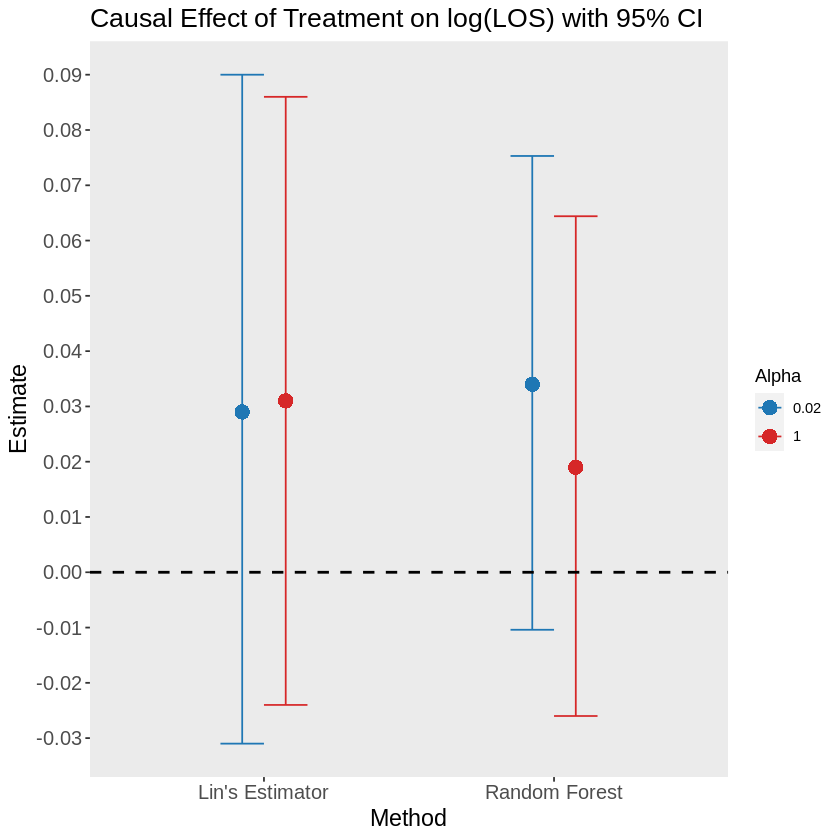

In [ ]:
data <- data_for_plot_LOS
my_colors <- c("#1f77b4", "#d62728")

ggplot(data, aes(x = Method, y = Estimate, color = factor(regularization_parameter), group = interaction(Method, regularization_parameter))) +
  geom_point(position = position_dodge(width = 0.3), size = 4, shape = 16) +
  geom_errorbar(aes(ymin = Lower_Bound, ymax = Upper_Bound),
                position = position_dodge(width = 0.3), width = 0.3) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.8) +
  labs(title = "Causal Effect of Treatment on log(LOS) with 95% CI", x = "Method", y = "Estimate") +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 12),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "right",
        plot.title = element_text(size = 16)) +
  scale_color_manual(values = my_colors) +
  guides(color = guide_legend(title = "Alpha")) +
  scale_y_continuous(breaks = seq(-2, 2, by = 0.01))



### Readmission

In [ ]:
data_for_plot_RAR <- data.frame(
  Method = c("Lin's Estimator", "Lin's Estimator",
  "Random Forest", "Random Forest"),
  regularization_parameter = c("0.01", "0.005", "0.01", "0.005"),
  Estimate = c(0.003, 0.005, 0.00558, 0.0075),
  Lower_Bound = c(-0.032, -0.031, -0.029132, -0.0265),
  Upper_Bound = c( 0.039, 0.04, 0.04031, 0.04163)
)


Method,regularization_parameter,Estimate,Lower_Bound,Upper_Bound
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Lin's Estimator,0.01,0.00300,-0.032000,0.03900
Lin's Estimator,0.005,0.00500,-0.031000,0.04000
Random Forest,0.01,0.00558,-0.029132,0.04031
Random Forest,0.005,0.00750,-0.026500,0.04163


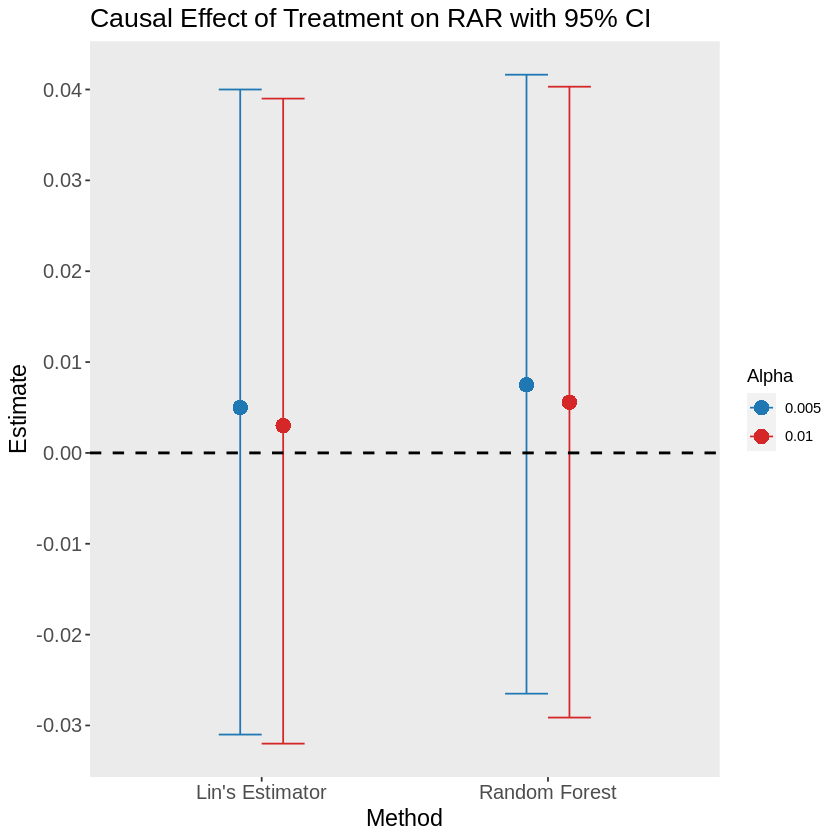

In [ ]:
data <- data_for_plot_RAR
my_colors <- c("#1f77b4", "#d62728")

ggplot(data, aes(x = Method, y = Estimate, color = factor(regularization_parameter), group = interaction(Method, regularization_parameter))) +
  geom_point(position = position_dodge(width = 0.3), size = 4, shape = 16) +
  geom_errorbar(aes(ymin = Lower_Bound, ymax = Upper_Bound),
                position = position_dodge(width = 0.3), width = 0.3) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.8) +
  labs(title = "Causal Effect of Treatment on RAR with 95% CI", x = "Method", y = "Estimate") +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 12),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "right",
        plot.title = element_text(size = 16)) +
  scale_color_manual(values = my_colors) +
  guides(color = guide_legend(title = "Alpha")) +
  scale_y_continuous(breaks = seq(-2, 2, by = 0.01))

